<h1><center><font size="6">LANL Earthquake EDA and Prediction</font></center></h1>

<h2><center><font size="4">Dataset used: LANL Earthquake Prediction</font></center></h2>

<img src="https://storage.googleapis.com/kaggle-media/competitions/LANL/nik-shuliahin-585307-unsplash.jpg" width="600"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

The data are from an experiment conducted on rock in a double direct shear geometry subjected to bi-axial loading, a classic laboratory earthquake model.

Two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults. While the experiment is considerably simpler than a fault in Earth, it shares many physical characteristics. 

Los Alamos' initial work showed that the prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles.   

In this competition, the team has provided a much more challenging dataset with considerably more aperiodic earthquake failures.  

Objective of the competition is to predict the failures for each test set.  

This solution uses  Andrew's Data Munging plus a quick Genetic Programming Model (from Scirpus's [Kernel](https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model/)).



# <a id='1'>Prepare the data analysis</a>

## Load packages

Here we define the packages for data manipulation, feature engineering and model training.

In [1]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

## Load the data

Let's see first what files we have in input directory.

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/LANL/"
else:
    PATH="../input/"
os.listdir(PATH)

['test', 'sample_submission.csv', 'train.csv']

Let's load the train file.

In [3]:
%%time
train_df = pd.read_csv(PATH+'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

CPU times: user 2min 23s, sys: 20.4 s, total: 2min 43s
Wall time: 2min 45s


Let's check the data imported.

In [4]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [5]:
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788
5,8,1.4690999777
6,9,1.4690999766
7,7,1.4690999755
8,-5,1.4690999744
9,3,1.4690999733


# <a id='3'>Data exploration</a>  

The dimmension of the data is quite large, in excess of 600 millions rows of data.  
The two columns in the train dataset have the following meaning:   
*  accoustic_data: is the accoustic signal measured in the laboratory experiment;  
* time to failure: this gives the time until a failure will occurs.

Let's plot 1% of the data. For this we will sample every 100 points of data.  

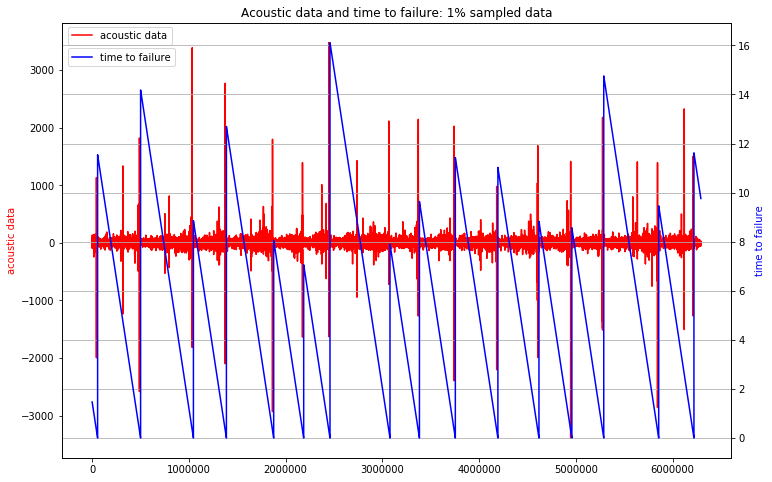

In [6]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

The plot shows only 1% of the full data. 
The acoustic data shows complex oscilations with variable amplitude. Just before each failure there is an increase in the amplitude of the acoustic data. We see that large amplitudes are also obtained at different moments in time (for example about the mid-time between two succesive failures).  

Let's plot as well the first 1% of the data.

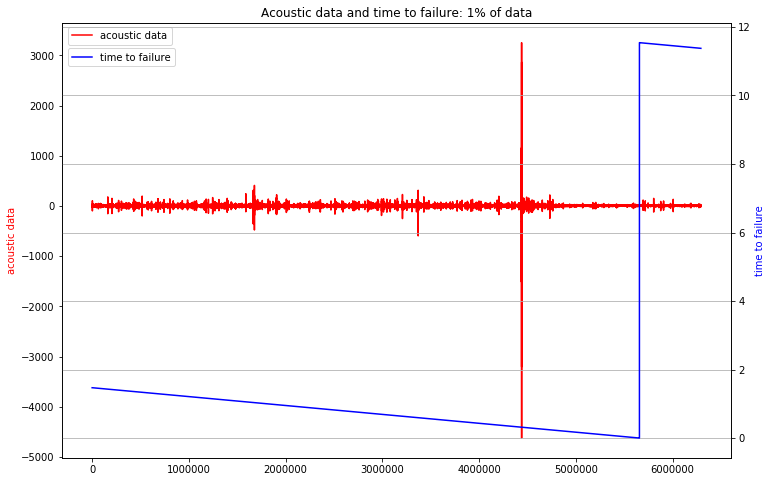

In [7]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

On this zoomed-in-time plot we can see that actually the large oscilation before the failure is not quite in the last moment. There are also trains of intense oscilations preceeding the large one and also some oscilations with smaller peaks after the large one. Then, after some minor oscilations, the failure occurs.

# <a id='4'>Features engineering</a>  

The test segments are 150,000 each.   
We split the train data in segments of the same dimmension with the test sets.

We will create additional aggregation features, calculated on the segments. 


In [8]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


Let's define some computation helper functions.

In [ ]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

Now let's calculate the aggregated functions for train set.

In [ ]:

train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

# iterate over all segments
for segment in tqdm(range(segments)):
    seg = train_df.iloc[segment*rows:segment*rows+rows]
    xc = pd.Series(seg['acoustic_data'].values)
    yc = seg['time_to_failure'].values[-1]
    
    train_y.loc[segment, 'time_to_failure'] = yc
    train_X.loc[segment, 'mean'] = xc.mean()
    train_X.loc[segment, 'std'] = xc.std()
    train_X.loc[segment, 'max'] = xc.max()
    train_X.loc[segment, 'min'] = xc.min()
    
    
    train_X.loc[segment, 'mean_change_abs'] = np.mean(np.diff(xc))
    train_X.loc[segment, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / x[:-1]))[0])
    train_X.loc[segment, 'abs_max'] = np.abs(xc).max()
    train_X.loc[segment, 'abs_min'] = np.abs(xc).min()
    
    train_X.loc[segment, 'std_first_50000'] = xc[:50000].std()
    train_X.loc[segment, 'std_last_50000'] = xc[-50000:].std()
    train_X.loc[segment, 'std_first_10000'] = xc[:10000].std()
    train_X.loc[segment, 'std_last_10000'] = xc[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = xc[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = xc[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = xc[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = xc[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

Let's check the result. We plot the head of X_train.

In [ ]:
X_tr.head(10)

We scale the data.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

Let's check the obtained dataframe.

In [ ]:
X_train_scaled.head(10)

# <a id='5'>Model</a>  

Let's prepare the model.

We read the submission file and prepare the test file.

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

We apply the same processing done for the training data to the test data.

In [ ]:
for i, seg_id in enumerate(tqdm(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

We scale also the test data.

In [ ]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
X_test_scaled.head(10)

In [ ]:
def GPI(data):
    return (5.612045 +
            0.0399999991*np.tanh(((((((((((data["q01_roll_std_100"]) + (((data["q05"]) + (((((((((data["q05"]) - ((((((data["iqr"]) + (((data["q05_roll_std_100"]) * 2.0)))) + (data["q01_roll_std_100"]))/2.0)))) * 2.0)) * 2.0)) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((10.0)) * ((((10.0)) * (((((data["q05"]) - (((((data["iqr"]) - (((((data["MA_700MA_BB_low_mean"]) - (((((data["q05_roll_std_10"]) * 2.0)) * 2.0)))) * 2.0)))) + (((data["q95"]) * 2.0)))))) - (data["q05_roll_std_10"]))))))) +
            0.0399999991*np.tanh((((9.0)) * ((((13.91913318634033203)) * ((((8.0)) * (((((data["q05_roll_mean_10"]) * 2.0)) - (((((((data["q05_roll_std_1000"]) + (data["iqr"]))) + ((((((9.0)) * (data["q05_roll_std_10"]))) * 2.0)))) + (data["q95_roll_mean_10"]))))))))))) +
            0.0399999991*np.tanh(((((((-3.0) - (((((((((((((data["q05_roll_std_100"]) - (data["q05"]))) + (data["q95"]))) * 2.0)) * 2.0)) + (((data["iqr"]) + (((((data["q05_roll_std_100"]) - (data["q05"]))) * 2.0)))))) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((-1.0*(((((12.37306118011474609)) * (((((data["iqr"]) * 2.0)) + (((data["q05_roll_std_1000"]) + (((data["q05_roll_std_10"]) + (((((((12.37306499481201172)) * (((((data["q05_roll_std_10"]) * 2.0)) + (data["ave_roll_std_100"]))))) + (data["abs_max_roll_mean_10"]))/2.0))))))))))))) * 2.0)) +
            0.0399999991*np.tanh(((-3.0) * (((((((((((((((((data["q95"]) + (((((data["q05_roll_std_10"]) * 2.0)) * 2.0)))) + (data["iqr"]))) - (data["q05_roll_mean_10"]))) + (((data["q95"]) + (data["q01_roll_std_100"]))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) +
            0.0399999991*np.tanh(((((((-3.0) * (((((((((data["iqr"]) + (((((((((((data["q05_roll_std_10"]) * 2.0)) * 2.0)) - (data["q05"]))) - (data["q05_roll_mean_10"]))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((data["iqr"]) + (data["av_change_abs_roll_mean_1000"]))) - ((8.0)))) - ((((((7.0)) * (((((((((data["q95"]) + (data["q05_roll_std_100"]))) * 2.0)) + (data["iqr"]))) + (data["MA_700MA_std_mean"]))))) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((((((((-1.0*((data["classic_sta_lta4_mean"])))) + ((((-1.0*((((((((((data["q05_roll_std_10"]) * 2.0)) * 2.0)) + (data["MA_1000MA_std_mean"]))) * ((10.0))))))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((6.0)) * ((((((((7.0)) * ((((((6.0)) * ((-1.0*((((data["iqr"]) - (((((data["MA_400MA_BB_low_mean"]) - (data["q05_roll_std_100"]))) * 2.0))))))))) - (((data["q05_roll_std_1000"]) * 2.0)))))) * 2.0)) * 2.0)))) +
            0.0399999991*np.tanh(((((((-1.0) - (((((((((data["q01_roll_std_10"]) + (((((((((data["q01_roll_std_10"]) + (((((data["q05_roll_std_10"]) - ((-1.0*((data["q05_roll_std_100"])))))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((((-1.0*((((((data["q05_roll_std_100"]) * 2.0)) + (np.tanh((((((((((data["q95"]) * 2.0)) * 2.0)) + (np.tanh(((9.00242137908935547)))))) * 2.0))))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((data["q01_roll_std_100"]) - (((((data["min_roll_std_100"]) + (((data["MA_400MA_BB_high_mean"]) * 2.0)))) - (((((((data["q05"]) - (((data["q05_roll_std_100"]) + (((data["q05_roll_std_10"]) * 2.0)))))) * 2.0)) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((8.36818313598632812)) * (((((((((((((((((((data["q01_roll_mean_10"]) - (((((data["q05_roll_std_10"]) * 2.0)) * 2.0)))) - (data["q05_roll_std_1000"]))) * 2.0)) * 2.0)) * 2.0)) - (data["min_roll_std_100"]))) * 2.0)) - (data["min"]))) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh((((14.20546531677246094)) * ((((4.79257917404174805)) * (((((data["max_first_50000"]) + (((np.tanh(((14.20546531677246094)))) / 2.0)))) - (((((data["iqr"]) - (((data["q05_roll_mean_10"]) - (data["q05_roll_std_100"]))))) * ((14.20546531677246094)))))))))) +
            0.0399999991*np.tanh((((13.87437629699707031)) * (((data["iqr"]) - ((((13.87437629699707031)) * ((((13.87437629699707031)) * (((((np.tanh((np.tanh((((data["q05_roll_std_100"]) + (data["abs_mean"]))))))) + (((data["q999"]) + (data["q05_roll_std_1000"]))))) + (data["iqr"]))))))))))) +
            0.0399999991*np.tanh(((((((data["max_to_min"]) - (((((((((((((((((((data["ave_roll_mean_1000"]) + ((((4.0)) * (data["q05_roll_std_10"]))))) * 2.0)) * 2.0)) * 2.0)) + ((4.0)))) * 2.0)) * 2.0)) + ((4.0)))) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((data["q05"]) + (((data["q99_roll_mean_100"]) + (((((data["q05"]) - (((data["q95"]) + (((data["q05_roll_std_100"]) + (((((data["q95"]) * 2.0)) + ((1.52700340747833252)))))))))) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((-3.0) + (((((((-3.0) + (((((data["min_last_10000"]) - (((((((data["exp_Moving_average_30000_mean"]) + (((((data["MA_400MA_std_mean"]) + (data["q05_roll_std_10"]))) * 2.0)))) * 2.0)) + (data["q05_roll_std_100"]))))) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((-1.0) - (((((data["q01_roll_std_1000"]) + (((((data["q05_roll_std_10"]) - (data["q05_roll_mean_10"]))) * 2.0)))) * 2.0)))) - (np.tanh((((np.tanh((data["min_roll_std_100"]))) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((3.67563223838806152)) - (((((((((((np.tanh(((3.67562866210937500)))) + (((data["iqr"]) + (((((data["exp_Moving_average_30000_mean"]) + (((((data["q05_roll_std_10"]) * 2.0)) * 2.0)))) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) +
            0.0399999991*np.tanh(((((((((((data["ave_roll_mean_1000"]) + (((((((data["ave_roll_mean_1000"]) + (((((((data["q05"]) - (((data["q05_roll_std_100"]) * 2.0)))) - (np.tanh((np.tanh((data["exp_Moving_average_3000_mean"]))))))) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((-3.0) - (((((data["avg_first_50000"]) + (((((data["iqr"]) + (((data["avg_first_50000"]) + (((((data["q05_roll_std_10"]) * 2.0)) * 2.0)))))) * 2.0)))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((data["q01_roll_mean_100"]) + (((((((data["q99_roll_mean_1000"]) - (((data["q05_roll_std_10"]) - (((((data["q05"]) - (((data["q05_roll_std_10"]) * 2.0)))) * 2.0)))))) * 2.0)) * 2.0)))) - (data["min_roll_std_1000"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((data["exp_Moving_average_30000_mean"]) - (((np.tanh((np.tanh((np.tanh((((data["Moving_average_3000_mean"]) + (((data["q05_roll_std_100"]) + (((data["q05_roll_std_100"]) * 2.0)))))))))))) * ((((11.90846347808837891)) + (((data["exp_Moving_average_30000_mean"]) * 2.0)))))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((((((-1.0*((((3.1415927410) + (((((data["q05_roll_mean_10"]) - (((((((((data["q05_roll_mean_10"]) * 2.0)) - (data["q05_roll_std_1000"]))) * 2.0)) * 2.0)))) * 2.0))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) - (3.1415927410))) +
            0.0399999991*np.tanh(((((data["ave10"]) - (((((np.tanh((((((((((((((((((data["q05_roll_std_100"]) + (np.tanh(((((data["iqr"]) + (data["exp_Moving_average_30000_mean"]))/2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh((((((((((((9.65306472778320312)) * (((0.3183098733) + (((((data["Moving_average_700_mean"]) + (data["q95_roll_std_100"]))) - (((((((data["q05_roll_std_10"]) * 2.0)) * 2.0)) * 2.0)))))))) - (((data["av_change_abs_roll_std_100"]) + (data["min_roll_std_100"]))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((-1.0*((((((data["sum"]) + (((((data["q05_roll_std_100"]) + (data["ave_roll_std_10"]))) * 2.0)))) * 2.0))))) - (((((((((data["ave_roll_std_10"]) * 2.0)) * 2.0)) * 2.0)) * (data["ave_roll_std_10"]))))) - (data["iqr"]))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((-1.0) + (((((((((((data["sum"]) - (((data["q05_roll_std_10"]) * (((((((5.0)) * 2.0)) + (data["exp_Moving_average_300_mean"]))/2.0)))))) * 2.0)) * 2.0)) - (data["Hilbert_mean"]))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((7.0)) * ((-1.0*((((((((((((((data["q01_roll_std_10"]) + (((data["q95_roll_mean_10"]) * 2.0)))) + (data["q01_roll_std_100"]))) * 2.0)) + (data["q05_roll_mean_1000"]))) + ((((data["abs_q05"]) + ((((data["q05_roll_std_100"]) + (data["kurt"]))/2.0)))/2.0)))) * 2.0))))))) +
            0.0399999991*np.tanh(((((((((0.3183098733) - (((((((data["q05_roll_std_100"]) - (np.tanh((((data["MA_400MA_BB_low_mean"]) - (np.tanh((((data["abs_q05"]) * (((data["std_first_50000"]) + (data["q05_roll_std_100"]))))))))))))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((data["q05_roll_mean_10"]) - ((((13.61857223510742188)) * (((data["q01_roll_mean_1000"]) - ((((data["max_to_min_diff"]) + (((((data["q01_roll_std_100"]) * 2.0)) - ((((13.61857223510742188)) * (((data["q05_roll_std_100"]) - ((((-1.0) + (data["q05_roll_mean_10"]))/2.0)))))))))/2.0)))))))) * 2.0)) +
            0.0399999991*np.tanh(((((data["q05_roll_std_100"]) - (((((data["abs_q05"]) + (((((((((data["q05_roll_std_1000"]) + (((((data["ave_roll_mean_1000"]) + (((data["q01_roll_std_10"]) + (data["q05_roll_std_100"]))))) + (((data["q95"]) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((((((((data["exp_Moving_average_300_mean"]) - ((((((((data["q05_roll_std_10"]) + (data["q01_roll_std_100"]))/2.0)) * 2.0)) * 2.0)))) * 2.0)) - (((data["abs_std"]) - (-1.0))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((data["min_roll_std_1000"]) - (((((((((((data["q05_roll_std_1000"]) + (((((((data["q95_roll_mean_10"]) * 2.0)) + (data["q05_roll_mean_100"]))) + (data["q05_roll_std_100"]))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((data["abs_q05"]) * 2.0)) - (((data["max_last_10000"]) + (((((((((data["q05_roll_std_1000"]) + (((((((data["q05_roll_std_100"]) + ((0.63752192258834839)))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((((-1.0*((((data["q95"]) + (((((np.tanh((((data["q05_roll_std_100"]) + (((data["ave_roll_mean_100"]) + (data["q05_roll_std_10"]))))))) * (((3.0) + (data["ave_roll_mean_100"]))))) * 2.0))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((((-1.0*((((((data["q95_roll_mean_1000"]) * (((np.tanh((np.tanh((((data["q05_roll_std_100"]) * 2.0)))))) * 2.0)))) + (((((data["q05_roll_std_100"]) * 2.0)) + (data["q05_roll_std_100"])))))))) - (data["q95_roll_mean_10"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((13.28551006317138672)) * (((((((((((-1.0) - (data["q05_roll_std_100"]))) * 2.0)) - (data["q05_roll_std_1000"]))) * 2.0)) - (-1.0))))) - (data["av_change_abs_roll_mean_100"]))) - (((data["max_last_10000"]) - (((data["avg_last_50000"]) - (data["max_last_10000"]))))))) +
            0.0399999991*np.tanh((-1.0*((((((((((data["max_roll_std_100"]) + (((((data["abs_q05"]) + (((((((((data["sum"]) + (((((data["q05_roll_std_100"]) + (data["q95"]))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)))) * 2.0)) * 2.0)) * 2.0))))) +
            0.0399999991*np.tanh(((((((((((((((((((data["q95_roll_mean_1000"]) - (((data["iqr"]) + (((data["q05_roll_std_1000"]) * 2.0)))))) * 2.0)) * 2.0)) - (((3.1415927410) + (((data["q05_roll_std_1000"]) * 2.0)))))) - (data["q05_roll_std_100"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((((((-1.0*((((data["q05_roll_std_10"]) + (((((data["ave_roll_mean_100"]) + (((3.0) * (((data["q05_roll_std_10"]) + (((data["q05_roll_std_10"]) - (data["iqr"]))))))))) * 2.0))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((9.0)) * ((-1.0*((((((((data["ave_roll_mean_100"]) * (np.tanh(((-1.0*((((data["ave_roll_mean_100"]) * (((data["MA_700MA_BB_high_mean"]) + (np.tanh((data["q05_roll_std_100"])))))))))))))) + (((((data["q95"]) * 2.0)) + (data["q05_roll_std_100"]))))) * 2.0))))))) +
            0.0399999991*np.tanh((((((data["iqr"]) + ((((8.59251594543457031)) + ((5.48695707321166992)))))/2.0)) - ((((8.59251594543457031)) * ((((8.59251594543457031)) * (((data["q01_roll_std_10"]) + (((((data["q95_roll_std_10"]) + (((data["Moving_average_6000_mean"]) + (((data["iqr"]) * 2.0)))))) * 2.0)))))))))) +
            0.0399999991*np.tanh((((((9.69162750244140625)) * 2.0)) * ((((9.69162750244140625)) * (((-1.0) - (((((data["min_roll_std_10"]) - ((((9.69163131713867188)) * (((((((-1.0) - (((data["q05_roll_std_100"]) - (data["q05"]))))) * 2.0)) * 2.0)))))) * 2.0)))))))) +
            0.0399999991*np.tanh(((((((((((((((((((((((data["ave10"]) * (data["ave_roll_mean_100"]))) - ((((-1.0*((data["q01_roll_std_100"])))) + (((((data["q05_roll_std_10"]) * 2.0)) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((data["classic_sta_lta1_mean"]) - ((((data["ave_roll_mean_1000"]) + ((((5.95361852645874023)) - (((((data["ave_roll_mean_1000"]) - ((((((((data["q05_roll_std_100"]) * 2.0)) * 2.0)) + (((data["iqr"]) + (data["q01_roll_std_1000"]))))/2.0)))) * ((14.64158535003662109)))))))/2.0)))) * ((14.64158535003662109)))) +
            0.0399999991*np.tanh(((((((((((((data["ave10"]) * (data["ave_roll_mean_10"]))) - (((((data["count_big"]) + (((data["q95"]) + (data["q05_roll_std_100"]))))) * 2.0)))) * 2.0)) * 2.0)) - (((data["q95_roll_mean_1000"]) + (((data["Moving_average_3000_mean"]) * (data["Moving_average_3000_mean"]))))))) * 2.0)) +
            0.0399999991*np.tanh((((((((-1.0*((((((data["q01_roll_std_1000"]) + (data["mean_change_rate_last_50000"]))) + (((((((((data["q05_roll_std_1000"]) + ((((-1.0*((data["q05"])))) + (data["q05_roll_std_1000"]))))) - ((-1.0*((2.0)))))) * 2.0)) * 2.0))))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((-1.0*(((((((((((((((((((((data["abs_std"]) + (data["abs_q05"]))/2.0)) + (((data["q95"]) * 2.0)))) + (((data["q01_roll_mean_1000"]) + (data["q05_roll_std_1000"]))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0))))) +
            0.0399999991*np.tanh(((((((((((((((((((((((((data["q05"]) * 2.0)) * 2.0)) + (((-3.0) - (((data["q01_roll_std_1000"]) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) + (data["q01_roll_std_1000"]))) * 2.0)) * 2.0)) * 2.0)) + (data["q01_roll_std_1000"]))) +
            0.0399999991*np.tanh(((((((((((((np.tanh(((((((((-1.0*((((data["exp_Moving_average_30000_mean"]) + (data["q05_roll_std_100"])))))) - (np.tanh((np.tanh((((data["q95"]) * 2.0)))))))) * 2.0)) * 2.0)))) * 2.0)) - (data["q01_roll_std_100"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((data["max_to_min_diff"]) + (((((((((((-1.0) - (data["q05_roll_std_1000"]))) * 2.0)) * 2.0)) - (((data["q05_roll_std_1000"]) - (data["q05"]))))) * 2.0)))) * 2.0)) + (data["abs_q05"]))) * 2.0)) + (data["q05_roll_std_1000"]))) * 2.0)) +
            0.0399999991*np.tanh(((((data["ave_roll_mean_10"]) - (((((np.tanh((((((((((data["std_last_50000"]) + (data["q05_roll_std_100"]))) - (((((np.tanh((data["q05"]))) * 2.0)) + (((data["ave_roll_mean_10"]) * (data["ave_roll_mean_10"]))))))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((data["skew"]) - (((((data["q05_roll_std_100"]) - (data["max_to_min"]))) - (((((data["q95_roll_mean_1000"]) + ((-1.0*((((data["q05_roll_std_100"]) + (data["q01_roll_std_10"])))))))) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((-1.0*((((((((((((((((data["Moving_average_1500_mean"]) + (((data["q05_roll_std_100"]) + ((((data["abs_max_roll_std_10"]) + (data["q05_roll_std_100"]))/2.0)))))) * 2.0)) * 2.0)) * 2.0)) * (((((data["q05_roll_std_100"]) * (data["q05_roll_std_100"]))) + (data["q05_roll_std_100"]))))) * 2.0)) * 2.0))))) +
            0.0399999991*np.tanh((((12.83482360839843750)) * ((((12.83482360839843750)) * ((((12.83482360839843750)) * (((np.tanh((np.tanh((((data["q99_roll_mean_10"]) - (((np.tanh((((data["q05_roll_std_100"]) - (data["q05"]))))) * (data["Moving_average_1500_mean"]))))))))) + (((data["q05"]) * 2.0)))))))))) +
            0.0399999991*np.tanh((((6.21923971176147461)) * ((((6.21923971176147461)) * ((-1.0*((((((data["q05_roll_std_10"]) * 2.0)) + (((data["abs_q05"]) - (np.tanh((((data["min_last_50000"]) + (((np.tanh((((((((data["q05_roll_std_10"]) * 2.0)) * 2.0)) * 2.0)))) * 2.0))))))))))))))))) +
            0.0399999991*np.tanh(((((((((data["max_to_min"]) + (((data["mean_change_rate_last_10000"]) + (((data["mean_change_rate_last_10000"]) + (((((((data["abs_q05"]) - (((data["q01_roll_std_10"]) * 2.0)))) - (((data["q01_roll_std_100"]) * 2.0)))) * 2.0)))))))) + (data["mean_change_rate_last_10000"]))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((((((-1.0*((data["q05_roll_std_10"])))) - (((((data["q01_roll_std_10"]) - (np.tanh((((((((((data["q05_roll_std_10"]) * 2.0)) * 2.0)) + (data["q05_roll_std_100"]))) * 2.0)))))) + (data["abs_q05"]))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((-2.0) - ((((10.60644054412841797)) * ((((10.60644054412841797)) * ((((np.tanh((data["iqr"]))) + (((((((((((data["q05_roll_std_1000"]) * 2.0)) - (-2.0))) * 2.0)) + (data["std_first_10000"]))) - (np.tanh((data["abs_q05"]))))))/2.0)))))))) +
            0.0399999991*np.tanh(((((((((((((data["Hann_window_mean"]) + (np.tanh((data["Hann_window_mean"]))))) - (((((np.tanh((((((data["q05_roll_std_100"]) + (((data["ave10"]) + (data["abs_max_roll_mean_100"]))))) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((np.tanh((((data["q01_roll_std_100"]) - (((data["q01_roll_std_10"]) * (data["q05_roll_std_10"]))))))) - (data["q01_roll_std_100"]))) - (((data["q05_roll_std_1000"]) - (np.tanh((((((data["q05_roll_std_10"]) * 2.0)) * 2.0)))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((data["exp_Moving_average_3000_mean"]) - (((data["q05_roll_std_10"]) + (((data["q01_roll_std_1000"]) - (((((np.tanh((data["MA_1000MA_std_mean"]))) - (data["q05_roll_std_10"]))) - (((((data["q05_roll_std_10"]) * (((data["abs_q05"]) * (data["q05_roll_std_10"]))))) * 2.0)))))))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((((((((((((data["min_roll_mean_10"]) - (((((data["sum"]) + (data["q05_roll_std_1000"]))) + (data["q95"]))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((((data["Moving_average_6000_mean"]) + (((((((((((-2.0) - (((data["q05_roll_std_100"]) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) + (data["q01_roll_std_10"]))) * 2.0)) * 2.0)) + (data["q01_roll_std_10"]))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((3.0) / 2.0)) - (((((((((data["q05_roll_std_100"]) - (((data["Moving_average_1500_mean"]) * (data["Moving_average_6000_mean"]))))) + (data["q05_roll_std_100"]))) * 2.0)) + (data["q05_roll_std_100"]))))) * 2.0)) * 2.0)) * 2.0)) - (data["min_roll_std_100"]))) * 2.0)) +
            0.0399999991*np.tanh(((((((data["q01_roll_std_100"]) + (((((((data["q01_roll_std_10"]) + (((((data["ave10"]) + (((((((((((-2.0) - (((data["q05_roll_std_100"]) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((data["exp_Moving_average_3000_mean"]) * (data["avg_first_50000"]))) - (((((((data["q95"]) * 2.0)) * (data["q05_roll_std_100"]))) * (((data["q05_roll_std_1000"]) + (1.0))))))) * (((3.0) + (((((1.0) + (data["exp_Moving_average_300_mean"]))) * 2.0)))))) +
            0.0399999991*np.tanh((((((((((((((((-1.0*((((data["q05_roll_std_10"]) - (np.tanh((((np.tanh((((data["q95_roll_std_100"]) * 2.0)))) * 2.0))))))))) * 2.0)) * 2.0)) * 2.0)) - (((data["iqr"]) * (data["abs_q05"]))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((-1.0*((((data["q95"]) + ((((((data["av_change_rate_roll_std_100"]) + (data["q95"]))/2.0)) + (((((((data["abs_q05"]) * (((data["ave_roll_std_100"]) + (data["max_roll_std_100"]))))) * 2.0)) + (((data["av_change_abs_roll_mean_10"]) + (((data["q05_roll_std_100"]) + (data["q95"])))))))))))))) +
            0.0399999991*np.tanh(((((data["q95_roll_std_1000"]) - ((((((((data["q01_roll_std_10"]) + (((((data["q95"]) * 2.0)) + (((data["iqr"]) * (data["mean"]))))))/2.0)) * 2.0)) * (((((data["iqr"]) * 2.0)) * (((data["q05_roll_std_1000"]) * 2.0)))))))) + (data["min_roll_std_1000"]))) +
            0.0399999991*np.tanh(((((data["skew"]) + (((((((((data["skew"]) + (((((((data["avg_last_10000"]) - (((data["q05_roll_std_100"]) - ((((data["q01_roll_std_10"]) + ((((-1.0*((data["q01_roll_std_10"])))) * 2.0)))/2.0)))))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh(((data["ave_roll_mean_10"]) - (((((((data["Moving_average_6000_mean"]) - (((3.0) - (((((data["q01_roll_std_10"]) - (((((data["Moving_average_6000_mean"]) * (data["Moving_average_6000_mean"]))) - (((((data["q05_roll_std_1000"]) - (data["min_roll_mean_10"]))) * 2.0)))))) * 2.0)))))) * 2.0)) * 2.0)))) +
            0.0399999991*np.tanh(((((data["avg_last_10000"]) - (((((data["min_roll_std_10"]) - (data["avg_last_10000"]))) - (data["avg_last_10000"]))))) - (((((3.1415927410) + (((((((((((((data["q05_roll_std_100"]) - (-1.0))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)))) +
            0.0399999991*np.tanh(((((((data["min"]) + (np.tanh((((((((((data["exp_Moving_average_30000_mean"]) * (data["exp_Moving_average_30000_mean"]))) - (((((0.3183098733) * (data["mean"]))) - (((((0.3183098733) - (data["q05_roll_std_100"]))) * 2.0)))))) * 2.0)) * 2.0)))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((((data["skew"]) - (((((((data["q01_roll_std_10"]) + (data["av_change_abs_roll_mean_10"]))) + (((3.1415927410) / 2.0)))) * 2.0)))) - (data["q95"]))) * 2.0)) * 2.0)) + (data["av_change_abs_roll_mean_10"]))) * 2.0)) - (data["q01_roll_std_10"]))) * 2.0)) +
            0.0399999991*np.tanh(((((data["skew"]) - (data["ave_roll_mean_10"]))) - (((((((((data["std_roll_mean_10"]) + ((2.45366740226745605)))) + (data["ave_roll_mean_10"]))) + (((data["av_change_rate_roll_std_1000"]) + (data["ave_roll_mean_10"]))))) + (((data["av_change_abs_roll_mean_10"]) + (((data["q01_roll_std_10"]) + (data["av_change_abs_roll_mean_10"]))))))))) +
            0.0399999991*np.tanh(((((((data["q95_roll_std_100"]) + (((data["abs_q05"]) * (((((((((np.tanh((data["q05_roll_std_100"]))) - ((-1.0*((((data["q01_roll_std_10"]) * (((data["q05_roll_std_100"]) * ((-1.0*((data["q05_roll_std_100"]))))))))))))) * 2.0)) * 2.0)) * 2.0)))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((data["mean_change_rate_first_10000"]) - ((-1.0*((((data["q95_roll_mean_10"]) + (((data["q01_roll_std_1000"]) + (data["q01_roll_std_1000"])))))))))) - (((((data["q05_roll_std_10"]) * (((data["q05_roll_std_100"]) * (data["q05_roll_std_1000"]))))) * (((data["q05_roll_std_100"]) * (((data["q05_roll_std_10"]) * 2.0)))))))) +
            0.0399999991*np.tanh((-1.0*((((((((((((((((data["q05_roll_std_1000"]) - (((((-1.0*((((data["Hann_window_mean"]) * (data["q05_roll_std_1000"])))))) + ((((2.0) + ((((data["ave10"]) + (data["min_last_10000"]))/2.0)))/2.0)))/2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0))))) +
            0.0399999991*np.tanh((((((-1.0*(((13.12281036376953125))))) * ((13.12281036376953125)))) * (((0.3183098733) + (((((data["q05_roll_std_100"]) + (np.tanh(((((13.12280750274658203)) + (((2.0) - (((data["q95_roll_mean_1000"]) * ((((13.12281036376953125)) * 2.0)))))))))))) * 2.0)))))) +
            0.0399999991*np.tanh(((((data["q05_roll_std_10"]) + (data["q05_roll_std_10"]))) * (np.tanh((((((data["q05_roll_std_100"]) + (data["Moving_average_1500_mean"]))) * (((((data["kurt"]) - (((data["q05_roll_std_10"]) + ((((((data["q01_roll_std_10"]) + ((10.0)))/2.0)) / 2.0)))))) - (data["q01_roll_std_10"]))))))))) +
            0.0399999991*np.tanh((((((12.48571777343750000)) * ((((((((-1.0*((((data["q05_roll_std_100"]) - (np.tanh(((((12.48571777343750000)) * ((((-1.0*((data["MA_400MA_BB_low_mean"])))) + (data["abs_q05"])))))))))))) * 2.0)) * 2.0)) * 2.0)))) - (((data["q95_roll_mean_1000"]) + ((12.48572158813476562)))))) +
            0.0399999991*np.tanh(((data["ave_roll_mean_10"]) + (((((((((((((data["min"]) + (((np.tanh((((((data["abs_max"]) * 2.0)) * 2.0)))) - ((((data["q95"]) + ((((data["ave_roll_mean_10"]) + (data["max_roll_std_10"]))/2.0)))/2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) +
            0.0399999991*np.tanh(((((((((((((data["av_change_rate_roll_std_10"]) * (data["max_to_min"]))) * 2.0)) * 2.0)) + (((data["q05_roll_std_1000"]) * ((((-1.0*((((((((data["mad"]) * 2.0)) + (data["max_to_min"]))) * 2.0))))) * 2.0)))))) + (data["skew"]))) + (data["av_change_rate_roll_std_10"]))) +
            0.0399999991*np.tanh(((data["min_last_10000"]) - (((data["min_roll_std_100"]) + (((data["av_change_abs_roll_mean_10"]) + (((data["std_first_10000"]) + ((((((-1.0*((((((data["min_roll_std_10"]) + (data["av_change_abs_roll_std_100"]))) + (data["max_first_10000"])))))) * (data["mean_change_abs"]))) + (data["av_change_abs_roll_mean_100"]))))))))))) +
            0.0399999991*np.tanh(((data["min_roll_mean_1000"]) - (((data["mean_change_rate_last_50000"]) - (((((((data["min"]) * (((data["kurt"]) + (data["q95_roll_mean_100"]))))) * 2.0)) - (np.tanh((((((data["q95_roll_mean_100"]) + (((((data["q01_roll_std_10"]) - (1.0))) * 2.0)))) * 2.0)))))))))) +
            0.0399999991*np.tanh(((((((((((data["q95"]) * (((data["q05_roll_std_10"]) * (((data["abs_q05"]) * (((((data["q05"]) - (data["q01_roll_std_10"]))) * 2.0)))))))) + ((((((data["q95_roll_std_10"]) * (data["abs_q05"]))) + (data["q05_roll_std_10"]))/2.0)))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((data["classic_sta_lta4_mean"]) - (((((((data["q05_roll_std_1000"]) - (((data["classic_sta_lta3_mean"]) + (((((data["q05_roll_std_1000"]) * (((((((data["classic_sta_lta4_mean"]) - (data["av_change_rate_roll_std_100"]))) - (data["skew"]))) - (data["q05_roll_std_1000"]))))) - (data["av_change_rate_roll_std_100"]))))))) * 2.0)) * 2.0)))) +
            0.0399999991*np.tanh((((((np.tanh((((np.tanh((data["kurt"]))) * 2.0)))) + (data["skew"]))/2.0)) - (((((np.tanh((data["q95_roll_mean_100"]))) + (((data["abs_max_roll_std_1000"]) * (data["kurt"]))))) - (((data["av_change_abs_roll_std_100"]) * (((data["std_first_10000"]) - (data["classic_sta_lta3_mean"]))))))))) +
            0.0399999991*np.tanh(((((data["min_roll_mean_1000"]) + (((data["q95_roll_mean_1000"]) + (data["q95_roll_mean_100"]))))) + (((data["iqr"]) * (((((np.tanh((((((((((((data["q95_roll_mean_100"]) * (data["q01"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)))))) +
            0.0399999991*np.tanh(((((((((((((((data["av_change_abs_roll_std_1000"]) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * (((((data["med"]) + (((data["min_roll_mean_10"]) - (data["min_first_10000"]))))) + (data["max_first_10000"]))))) - (((data["q999"]) - (((data["min_roll_mean_10"]) * 2.0)))))) +
            0.0399999991*np.tanh(((((((((((np.tanh((((data["q05_roll_std_10"]) + (data["avg_first_10000"]))))) + (data["q95_roll_mean_100"]))) * ((-1.0*((((data["q05_roll_std_1000"]) - (np.tanh((np.tanh((np.tanh((((data["max_last_10000"]) + (data["avg_first_10000"])))))))))))))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((data["q05_roll_mean_10"]) * (((data["q05_roll_std_1000"]) * (data["q05_roll_std_100"]))))) * (((data["q05_roll_std_1000"]) * (data["q05_roll_std_1000"]))))) + (np.tanh((((((((((data["sum"]) + (data["q01_roll_std_1000"]))) + (data["q05_roll_std_10"]))) + (data["q95_roll_std_10"]))) * 2.0)))))) +
            0.0399999991*np.tanh(((((((((((data["mean_change_rate_first_10000"]) - (((((((data["q95"]) - (data["q95_roll_std_10"]))) * 2.0)) * 2.0)))) - (((data["q95"]) - (((data["classic_sta_lta2_mean"]) * (data["av_change_abs_roll_mean_10"]))))))) * 2.0)) - (data["av_change_abs_roll_mean_10"]))) * 2.0)) +
            0.0374208651*np.tanh(((((((((((((data["q01"]) * (((data["mean_change_rate"]) + (data["q01_roll_std_1000"]))))) + (((data["q95_roll_mean_1000"]) * ((((-1.0*((data["std_roll_mean_1000"])))) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) + ((-1.0*((data["std_roll_mean_1000"])))))) +
            0.0399999991*np.tanh(((data["min_roll_mean_1000"]) + (np.tanh((((((data["std_first_50000"]) * ((((-1.0*((((((((((data["q95_roll_mean_1000"]) + (data["std_first_50000"]))) * 2.0)) * 2.0)) * 2.0))))) * 2.0)))) * (((((((data["q99_roll_std_10"]) + (data["std_last_50000"]))) * 2.0)) * 2.0)))))))) +
            0.0399999991*np.tanh(((((((((data["std_first_50000"]) * (data["max_last_10000"]))) + (((((((data["std_first_50000"]) * (data["classic_sta_lta4_mean"]))) + (((data["kurt"]) * (np.tanh((((((data["max_to_min_diff"]) - (data["max_last_10000"]))) + (data["max_to_min_diff"]))))))))) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((-1.0*((((data["min_roll_mean_1000"]) * (((((((((data["av_change_abs_roll_std_10"]) - (((((((data["q95_roll_mean_100"]) + (((data["q95_roll_mean_100"]) - (data["classic_sta_lta2_mean"]))))/2.0)) + (((((data["classic_sta_lta2_mean"]) + (data["q05_roll_std_10"]))) * (data["q95_roll_mean_100"]))))/2.0)))) * 2.0)) * 2.0)) * 2.0))))))) +
            0.0399999991*np.tanh(((data["min_roll_mean_1000"]) + (((data["q95_roll_std_100"]) + (((data["q01_roll_mean_10"]) * (((data["max_first_50000"]) + (((((((data["av_change_rate_roll_mean_10"]) - (data["min_roll_std_1000"]))) * 2.0)) + (((((((data["av_change_rate_roll_mean_10"]) * 2.0)) * (data["av_change_rate_roll_mean_10"]))) * (data["iqr"]))))))))))))) +
            0.0399843678*np.tanh(((data["q05_roll_std_1000"]) * (((((data["abs_q05"]) + (data["mean_change_rate_first_10000"]))) - (((data["classic_sta_lta2_mean"]) - (((data["abs_q05"]) - (((((((data["q05_roll_std_1000"]) * (data["q05_roll_std_1000"]))) - (data["classic_sta_lta4_mean"]))) - (((0.3183098733) + (data["classic_sta_lta4_mean"]))))))))))))) +
            0.0399999991*np.tanh((((((((((data["MA_700MA_std_mean"]) * (((data["q99_roll_mean_1000"]) * 2.0)))) + (((((data["av_change_abs_roll_mean_1000"]) + (data["min_roll_std_10"]))) + (data["q01_roll_std_100"]))))/2.0)) + (data["q95_roll_std_1000"]))) * (((data["q01_roll_mean_100"]) * (((((((data["q99_roll_mean_1000"]) * 2.0)) * 2.0)) * 2.0)))))) +
            0.0399531052*np.tanh(((((((((data["max_to_min"]) - (data["std_first_50000"]))) - (data["std_first_50000"]))) * (((((((data["q05_roll_std_10"]) * (data["q05_roll_std_10"]))) - (data["exp_Moving_average_300_mean"]))) + (((data["av_change_rate_roll_mean_10"]) * 2.0)))))) + ((((data["std_first_50000"]) + (data["mean_change_abs"]))/2.0)))) +
            0.0399999991*np.tanh((((((data["skew"]) + ((((data["skew"]) + (data["abs_max_roll_mean_1000"]))/2.0)))/2.0)) * (((data["av_change_rate_roll_mean_10"]) - (((((data["max_roll_std_100"]) * (((data["med"]) - (((data["av_change_rate_roll_mean_10"]) - (data["abs_max_roll_mean_1000"]))))))) * (((data["q95_roll_mean_1000"]) + (data["skew"]))))))))) +
            0.0399999991*np.tanh(((data["min_roll_std_100"]) * ((((((((data["abs_q05"]) - (data["av_change_rate_roll_std_10"]))) + ((((((((((data["min_roll_std_100"]) - (data["mean_change_rate_last_10000"]))) - (data["q01_roll_std_100"]))) + (((data["min_roll_std_100"]) - (data["q01_roll_std_100"]))))/2.0)) - (data["max_to_min"]))))/2.0)) - (data["q99_roll_mean_1000"]))))) +
            0.0387338810*np.tanh((-1.0*((((((data["mean_change_rate"]) + (((((data["av_change_abs_roll_std_10"]) * 2.0)) + (((data["mean_change_abs"]) + (((((((((data["av_change_abs_roll_std_10"]) * 2.0)) + (data["av_change_abs_roll_std_10"]))) + (data["av_change_abs_roll_std_10"]))) * (data["av_change_abs_roll_std_10"]))))))))) * (data["av_change_rate_roll_mean_1000"])))))) +
            0.0399999991*np.tanh(((data["MA_700MA_BB_low_mean"]) * (((data["q95_roll_std_100"]) * (((((((data["av_change_abs_roll_mean_10"]) + (data["min_roll_mean_100"]))) + (((((data["q95_roll_mean_1000"]) * (data["max_roll_mean_1000"]))) + (data["std_last_10000"]))))) + (((((data["Moving_average_700_mean"]) * (data["std_last_10000"]))) + (data["med"]))))))))) +
            0.0399999991*np.tanh(((data["min_last_10000"]) * (((data["mean_change_rate_last_10000"]) - (((((((data["min_roll_std_1000"]) + (((np.tanh((data["min_roll_std_1000"]))) + (((np.tanh((((data["min_last_50000"]) / 2.0)))) - (data["q99_roll_std_1000"]))))))) + (data["av_change_rate_roll_mean_100"]))) + (np.tanh((data["max_to_min"]))))))))) +
            0.0399999991*np.tanh(((data["q05"]) * (((((data["max_first_50000"]) + (((data["max"]) / 2.0)))) - (((data["q01_roll_std_100"]) * (np.tanh((((((data["skew"]) + (data["kurt"]))) - (((data["MA_400MA_BB_low_mean"]) + (((data["q01_roll_std_100"]) + (data["abs_q05"]))))))))))))))) +
            0.0399687365*np.tanh((((((((data["av_change_rate_roll_std_10"]) + (data["abs_mean"]))/2.0)) + (data["min_roll_mean_1000"]))) + (np.tanh((((data["min_roll_std_10"]) - ((((((((((((data["av_change_rate_roll_std_10"]) + (data["abs_mean"]))/2.0)) + (data["abs_mean"]))) * 2.0)) * ((-1.0*((data["min_roll_std_10"])))))) * 2.0)))))))) +
            0.0399999991*np.tanh(((((((data["q99_roll_std_100"]) * (((data["q01_roll_mean_1000"]) - (((((data["std_last_10000"]) - (((((((data["av_change_abs_roll_std_100"]) + (data["av_change_abs_roll_mean_100"]))) + (data["q05_roll_std_10"]))) * (data["av_change_abs_roll_std_100"]))))) - (((data["kurt"]) * (data["q01_roll_std_10"]))))))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((data["min_roll_mean_1000"]) - (((((data["skew"]) * 2.0)) * ((-1.0*((((data["av_change_abs_roll_std_100"]) + (((((data["max_first_10000"]) + ((((data["mean_change_rate_last_10000"]) + (np.tanh((((np.tanh((data["mean_change_rate_last_10000"]))) * (data["q95"]))))))/2.0)))) * (data["q95_roll_std_1000"])))))))))))) +
            0.0399999991*np.tanh((((((((data["avg_first_50000"]) + ((1.16062068939208984)))/2.0)) - (data["q01_roll_std_100"]))) * (((data["q95_roll_mean_1000"]) + ((-1.0*((np.tanh((((data["Moving_average_3000_mean"]) - ((((1.16062068939208984)) - (((data["mean_change_rate_first_10000"]) - (data["q01_roll_std_100"])))))))))))))))) +
            0.0399843678*np.tanh(((data["min_roll_mean_1000"]) - ((-1.0*(((((((data["min_roll_mean_1000"]) + (data["abs_max_roll_std_1000"]))/2.0)) - ((-1.0*((((data["q95_roll_std_1000"]) + (((np.tanh((((data["classic_sta_lta4_mean"]) * (((data["abs_max_roll_std_1000"]) + (data["av_change_abs_roll_mean_10"]))))))) - (data["q05_roll_std_1000"]))))))))))))))) +
            0.0383118391*np.tanh((-1.0*((((((data["mean_change_rate_first_50000"]) * (data["mean_change_rate_first_50000"]))) + (((data["std_last_10000"]) - ((((data["min_roll_std_1000"]) + (((((data["min_roll_std_1000"]) + ((((((data["mean_change_rate_last_50000"]) * (data["min_roll_std_1000"]))) + (((data["std_first_10000"]) * 2.0)))/2.0)))) * (data["min_roll_std_1000"]))))/2.0))))))))) +
            0.0364986323*np.tanh(((((data["q95_roll_std_1000"]) * 2.0)) * (((((data["q01_roll_mean_1000"]) + (((((data["q95_roll_std_1000"]) + (data["mean_change_rate_last_10000"]))) * (((data["q95_roll_std_1000"]) + (((data["max_to_min_diff"]) + (((data["min_roll_mean_1000"]) * (((data["q95_roll_mean_1000"]) * 2.0)))))))))))) + (data["mean_change_rate_last_10000"]))))) +
            0.0399999991*np.tanh(((data["min_first_10000"]) * (((data["min_roll_std_1000"]) * (((((data["kurt"]) - (data["av_change_abs_roll_std_10"]))) - (((((data["max_to_min"]) + (((((data["avg_first_50000"]) - (data["med"]))) - (data["av_change_rate_roll_mean_100"]))))) + (((data["min_first_10000"]) * (data["med"]))))))))))) +
            0.0399843678*np.tanh((((((data["max_to_min"]) * (data["min_roll_std_10"]))) + (((((((data["min"]) * (((data["q95_roll_mean_1000"]) * (((((data["min_roll_std_10"]) - (data["max_first_10000"]))) - (((data["max_to_min"]) * (((data["av_change_abs_roll_std_10"]) + (data["av_change_abs_roll_std_10"]))))))))))) * 2.0)) * 2.0)))/2.0)) +
            0.0399843678*np.tanh(((data["q01_roll_std_1000"]) * ((((((((((((data["MA_1000MA_std_mean"]) + (data["min_roll_std_10"]))) + (data["av_change_abs_roll_std_10"]))) + (((data["max_to_min"]) + (data["av_change_abs_roll_std_10"]))))) + (0.3183098733))/2.0)) * ((-1.0*((((data["med"]) + (((0.3183098733) * 2.0))))))))))) +
            0.0399999991*np.tanh(((data["min_last_10000"]) * ((-1.0*((((data["mean_change_rate_first_10000"]) - (((data["MA_400MA_BB_low_mean"]) * (((((((((data["mean_change_rate_first_10000"]) - (((((data["skew"]) * 2.0)) - (data["mean_change_rate_first_10000"]))))) - (data["min_last_10000"]))) - (data["skew"]))) * (data["mean_change_rate_first_10000"])))))))))))) +
            0.0399843678*np.tanh(((data["q01_roll_std_100"]) * (((((((((((data["classic_sta_lta3_mean"]) * (data["abs_max_roll_mean_1000"]))) * (data["av_change_abs_roll_std_100"]))) + (((((data["classic_sta_lta1_mean"]) + (((data["min_roll_std_1000"]) - (data["av_change_abs_roll_std_100"]))))) - (data["av_change_abs_roll_std_100"]))))) * (data["min_roll_mean_1000"]))) - (data["av_change_abs_roll_std_100"]))))) +
            0.0399999991*np.tanh(((((data["trend"]) * ((((data["q95"]) + (data["min_roll_std_100"]))/2.0)))) * ((-1.0*(((((((((((data["av_change_abs_roll_std_1000"]) - (data["av_change_abs_roll_std_100"]))) - (data["classic_sta_lta4_mean"]))) + (((data["classic_sta_lta4_mean"]) * (data["abs_q99"]))))/2.0)) + (data["mean_change_rate_last_10000"])))))))) +
            0.0399843678*np.tanh(((((data["q05"]) * (((((((-1.0*((data["q01_roll_mean_1000"])))) + (data["med"]))/2.0)) - (data["mean_change_rate_first_10000"]))))) * (((data["q01_roll_std_1000"]) + (((((data["iqr"]) + (data["med"]))) + (np.tanh((((data["mean_change_rate_first_10000"]) + (data["q01_roll_mean_1000"]))))))))))) +
            0.0399843678*np.tanh(((data["avg_first_10000"]) * (((data["abs_q95"]) * (((data["min_roll_mean_100"]) - ((((((data["min_roll_std_10"]) + ((-1.0*((data["max_first_10000"])))))/2.0)) * (((((data["avg_last_10000"]) + (((data["avg_first_10000"]) * (data["max_to_min"]))))) + (data["av_change_abs_roll_std_1000"]))))))))))) +
            0.0399999991*np.tanh(((data["std_roll_mean_1000"]) * ((((data["min_roll_std_10"]) + (((((data["ave_roll_std_1000"]) + ((-1.0*((data["mean_change_rate"])))))) * (((((data["mean_change_rate"]) + (data["abs_max_roll_std_1000"]))) * ((-1.0*(((((((data["min_roll_std_10"]) + (data["mean_change_rate"]))/2.0)) + (data["trend"])))))))))))/2.0)))) +
            0.0399999991*np.tanh(((data["av_change_abs_roll_mean_1000"]) * ((((((-1.0*((((data["mean_change_abs"]) * (((data["q95_roll_mean_10"]) + ((((data["av_change_abs_roll_std_100"]) + (data["av_change_abs_roll_mean_1000"]))/2.0))))))))) + (((data["max_roll_mean_100"]) + (((data["mean_change_rate_last_50000"]) - (np.tanh((data["max_last_10000"]))))))))) * (data["max_last_10000"]))))) +
            0.0399687365*np.tanh(((((data["max_first_10000"]) - (((np.tanh((np.tanh((((data["min_roll_std_100"]) + (((data["min_roll_std_100"]) + (data["Hann_window_mean"]))))))))) - ((((((data["av_change_abs_roll_std_10"]) + (data["max_last_50000"]))/2.0)) + (((data["abs_max_roll_mean_100"]) * (data["min_roll_mean_10"]))))))))) * (data["trend"]))) +
            0.0399999991*np.tanh((((((data["av_change_rate_roll_std_10"]) - (data["av_change_rate_roll_std_1000"]))) + (((data["classic_sta_lta1_mean"]) * (((((data["mean_change_rate_last_10000"]) + (data["q01_roll_std_100"]))) * (((data["classic_sta_lta1_mean"]) * (((data["classic_sta_lta1_mean"]) * ((((((data["mean_change_rate_last_10000"]) + (data["q99_roll_std_1000"]))/2.0)) * (data["min_first_50000"]))))))))))))/2.0)) +
            0.0399843678*np.tanh(((data["av_change_abs_roll_std_10"]) * (((((data["skew"]) + (data["mean_change_rate_last_50000"]))) - (((((data["abs_trend"]) - (data["mean_change_rate_last_10000"]))) - (((data["av_change_abs_roll_mean_100"]) * (((data["av_change_abs_roll_std_10"]) + (((data["skew"]) + (((data["max_last_10000"]) + (data["min_roll_std_10"]))))))))))))))) +
            0.0379054286*np.tanh((-1.0*(((((((np.tanh((data["trend"]))) + (((data["classic_sta_lta3_mean"]) * (((data["trend"]) + (data["max_roll_mean_1000"]))))))/2.0)) + (((data["mean_change_abs"]) * (np.tanh((((data["classic_sta_lta3_mean"]) * 2.0))))))))))) +
            0.0399687365*np.tanh(((((((data["av_change_rate_roll_mean_100"]) * (data["trend"]))) - (np.tanh((((data["mean_change_rate"]) * (((data["av_change_abs_roll_mean_100"]) + (((data["min_roll_std_1000"]) - (((data["mean_change_rate_last_10000"]) - (((data["mean_change_rate"]) * ((((data["av_change_abs_roll_mean_100"]) + (data["max_to_min"]))/2.0)))))))))))))))) / 2.0)) +
            0.0399999991*np.tanh(((data["mean_change_rate_last_10000"]) * (((data["av_change_abs_roll_std_1000"]) + ((((((((data["max_last_10000"]) - (data["q05"]))) * (data["max_to_min"]))) + ((((-1.0*((data["av_change_abs_roll_std_10"])))) - (((data["max_last_10000"]) - (((data["mean_change_rate_last_10000"]) * (data["q05"]))))))))/2.0)))))) +
            0.0399843678*np.tanh((((((data["q95_roll_std_1000"]) + (((data["q95_roll_std_1000"]) * ((((data["q01_roll_mean_1000"]) + (((data["q01_roll_mean_1000"]) + (data["std_roll_mean_100"]))))/2.0)))))/2.0)) - (np.tanh((np.tanh(((((np.tanh((data["std_first_10000"]))) + (np.tanh((np.tanh((((data["av_change_abs_roll_mean_10"]) * 2.0)))))))/2.0)))))))) +
            0.0399843678*np.tanh(((data["q95_roll_mean_10"]) * (((data["mean_change_rate_first_10000"]) * (((-1.0) * (((((((((data["av_change_rate_roll_mean_100"]) + (((-1.0) - (data["mean_change_rate_first_10000"]))))/2.0)) + (((data["min_roll_std_10"]) - (data["mean_change_rate_first_50000"]))))/2.0)) + (data["mean_change_rate_last_50000"]))))))))) +
            0.0399843678*np.tanh(((data["max_roll_std_100"]) * (((((data["mean_change_rate_first_50000"]) - (((data["classic_sta_lta2_mean"]) * (((data["av_change_rate_roll_std_10"]) + (data["med"]))))))) - (((((data["av_change_rate_roll_std_10"]) * (data["mean_change_rate_first_50000"]))) + (((((data["mean_change_rate_first_50000"]) * (data["av_change_rate_roll_std_10"]))) + (data["med"]))))))))) +
            0.0374521278*np.tanh(np.tanh(((-1.0*((((((((data["min_first_50000"]) * (data["mean_change_rate_last_50000"]))) + (data["q95"]))) + ((((data["av_change_abs_roll_std_100"]) + (((data["mean_change_rate_last_50000"]) * (((data["avg_last_50000"]) + (((data["mean_change_rate_last_50000"]) + ((-1.0*((data["av_change_abs_roll_std_10"])))))))))))/2.0))))))))) +
            0.0399999991*np.tanh(((((data["q95_roll_std_10"]) * (data["q01_roll_mean_1000"]))) + (((data["q95_roll_std_1000"]) - (((data["q05_roll_std_10"]) * ((((data["avg_last_10000"]) + (((data["q05_roll_std_10"]) * (((((((((data["max_roll_mean_100"]) * (data["classic_sta_lta3_mean"]))) + (data["q05_roll_std_100"]))/2.0)) + (data["q05_roll_std_100"]))/2.0)))))/2.0)))))))) +
            0.0399843678*np.tanh(((data["std_roll_mean_1000"]) * (((data["classic_sta_lta1_mean"]) + (((data["classic_sta_lta1_mean"]) + (((data["MA_400MA_BB_low_mean"]) * (((data["q95_roll_mean_1000"]) + (((((data["classic_sta_lta1_mean"]) * (data["max_last_10000"]))) + (((((data["max_last_10000"]) * 2.0)) + (((data["classic_sta_lta2_mean"]) * 2.0)))))))))))))))) +
            0.0399843678*np.tanh(((data["mean_change_abs"]) * (((((((data["min_first_50000"]) * 2.0)) * (data["av_change_abs_roll_std_10"]))) + (np.tanh((((((((((data["mean_change_rate_first_50000"]) + (((data["av_change_abs_roll_std_100"]) - (((data["q95_roll_mean_10"]) - (((data["min_first_50000"]) * 2.0)))))))) * 2.0)) * 2.0)) * 2.0)))))))) +
            0.0399687365*np.tanh((((((data["min_last_50000"]) * (data["av_change_abs_roll_std_10"]))) + (((((((data["max_roll_mean_100"]) + ((-1.0*((data["av_change_abs_roll_std_1000"])))))/2.0)) + (((data["q95_roll_mean_1000"]) * ((-1.0*(((((data["q05_roll_std_100"]) + ((((data["av_change_abs_roll_std_10"]) + ((((data["av_change_abs_roll_std_10"]) + (data["max_roll_mean_100"]))/2.0)))/2.0)))/2.0))))))))/2.0)))/2.0)) +
            0.0399843678*np.tanh(((((data["max_roll_mean_100"]) + (((data["q01_roll_mean_1000"]) * ((((np.tanh((data["max_to_min_diff"]))) + (((data["q99"]) - (((data["kurt"]) * (np.tanh((data["q95"]))))))))/2.0)))))) - (((data["kurt"]) * (np.tanh((data["q999"]))))))) +
            0.0397186391*np.tanh(((data["min_roll_mean_1000"]) * (((data["avg_last_10000"]) * ((((((((((((data["std_roll_std_10"]) + (data["iqr"]))/2.0)) + (data["min_roll_std_10"]))) + (data["classic_sta_lta1_mean"]))) + (((data["avg_last_10000"]) * (data["std_roll_std_10"]))))) + ((((data["trend"]) + (data["iqr"]))/2.0)))))))) +
            0.0399531052*np.tanh(((data["q99_roll_std_1000"]) * (((np.tanh((((((((((((data["ave_roll_mean_1000"]) + (((np.tanh((((((data["q05_roll_mean_1000"]) + (((data["q05_roll_mean_1000"]) + ((-1.0*((data["classic_sta_lta1_mean"])))))))) * 2.0)))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)))) +
            0.0399218425*np.tanh((((((data["MA_400MA_BB_low_mean"]) * (((((((data["avg_first_10000"]) * 2.0)) * 2.0)) * (((data["abs_max_roll_mean_100"]) * (data["min_roll_std_1000"]))))))) + (((np.tanh((((((((((((((data["avg_first_10000"]) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) / 2.0)))/2.0)) +
            0.0399999991*np.tanh((((((-1.0*((data["classic_sta_lta3_mean"])))) * (data["std_roll_mean_1000"]))) * ((((((data["av_change_rate_roll_mean_100"]) + (((data["q05_roll_std_1000"]) * ((((-1.0*((data["ave_roll_mean_1000"])))) + (data["av_change_rate_roll_mean_100"]))))))/2.0)) + (((((2.0) + (data["med"]))) + (data["q95_roll_mean_100"]))))))) +
            0.0399843678*np.tanh(((data["q99_roll_std_10"]) * (((data["q01_roll_mean_1000"]) + (((((data["min_roll_std_100"]) * ((((((((data["q01_roll_mean_1000"]) + (data["min_roll_std_100"]))/2.0)) + (data["av_change_abs_roll_mean_1000"]))) + (data["q01_roll_mean_1000"]))))) + (((data["min_roll_std_100"]) + ((((data["av_change_abs_roll_mean_1000"]) + (data["min_last_50000"]))/2.0)))))))))) +
            0.0399687365*np.tanh((((-1.0*((((data["q95_roll_std_10"]) * (np.tanh((((((((((data["q99_roll_std_100"]) * (((data["exp_Moving_average_30000_mean"]) - (((data["avg_last_10000"]) * (((((data["avg_last_10000"]) - (data["max_roll_std_100"]))) - (data["max_roll_std_100"]))))))))) * 2.0)) * 2.0)) * 2.0))))))))) / 2.0)) +
            0.0396404825*np.tanh((((-1.0*((data["abs_trend"])))) * (((((((data["abs_trend"]) + (((((data["abs_trend"]) + (((data["max_roll_mean_1000"]) * 2.0)))) * (((data["max_roll_mean_1000"]) * 2.0)))))) * 2.0)) * 2.0)))) +
            0.0399531052*np.tanh((((np.tanh((((((((data["mean_change_rate_last_10000"]) * (data["av_change_rate_roll_std_10"]))) + (data["max_last_50000"]))) + (((data["max_first_10000"]) + (data["mean_change_rate_last_10000"]))))))) + (((data["ave_roll_mean_1000"]) * (np.tanh((((((data["med"]) * (data["max_last_50000"]))) + (data["mean_change_rate_last_10000"]))))))))/2.0)) +
            0.0397499017*np.tanh((((((((data["q99_roll_mean_100"]) + (((data["std_last_10000"]) * (((((((data["q05_roll_mean_100"]) + (data["mean_change_abs"]))) + (data["skew"]))) * 2.0)))))/2.0)) * (data["max_last_50000"]))) * 2.0)) +
            0.0399999991*np.tanh(((data["abs_max_roll_std_1000"]) * (((((((data["max_last_10000"]) + (((((data["mean_change_rate"]) * 2.0)) * ((-1.0*(((((data["q01"]) + (((data["max_roll_mean_1000"]) * (((data["abs_max_roll_mean_10"]) + (((data["mean_change_rate"]) + (data["max_roll_mean_1000"]))))))))/2.0))))))))) * 2.0)) * 2.0)))) +
            0.0399999991*np.tanh((((-1.0*((np.tanh((((np.tanh((((data["av_change_abs_roll_std_1000"]) * 2.0)))) * 2.0))))))) + (np.tanh((((((data["av_change_abs_roll_std_1000"]) * 2.0)) * (((((((9.0)) + (data["av_change_abs_roll_std_1000"]))/2.0)) * 2.0)))))))) +
            0.0399999991*np.tanh(((data["min_first_10000"]) * (((data["iqr"]) * (((((data["std_roll_mean_1000"]) + (data["av_change_rate_roll_mean_100"]))) + (((data["av_change_rate_roll_mean_100"]) + ((((((data["av_change_rate_roll_std_1000"]) * (((data["av_change_rate_roll_mean_100"]) * (data["iqr"]))))) + (((data["abs_q05"]) * (data["av_change_rate_roll_mean_100"]))))/2.0)))))))))) +
            0.0398280546*np.tanh(np.tanh(((-1.0*((((data["av_change_abs_roll_mean_100"]) * (((data["max_first_50000"]) - (((((data["std_roll_std_10"]) - (data["q01_roll_mean_100"]))) - (((data["min_roll_std_100"]) - ((((((data["min_roll_std_1000"]) + (data["classic_sta_lta3_mean"]))) + ((((data["q01_roll_mean_100"]) + (data["av_change_abs_roll_mean_100"]))/2.0)))/2.0))))))))))))))) +
            0.0399531052*np.tanh(((data["mean_change_abs"]) * ((((data["min_roll_std_10"]) + ((((((((data["min_roll_std_10"]) * (data["trend"]))) - (((data["mean_change_rate_last_10000"]) * (((((data["min_last_10000"]) - (data["q01_roll_mean_1000"]))) - (data["av_change_rate_roll_std_100"]))))))) + (((data["trend"]) - (data["av_change_rate_roll_std_100"]))))/2.0)))/2.0)))) +
            0.0371082425*np.tanh(((data["av_change_abs_roll_mean_1000"]) * (((((data["std_first_10000"]) + ((((data["mean_change_abs"]) + (np.tanh((np.tanh((data["av_change_abs_roll_mean_1000"]))))))/2.0)))) * (((data["av_change_rate_roll_mean_10"]) + (((((data["std_first_10000"]) * (data["std_first_10000"]))) * (((data["std_first_10000"]) + (data["std_first_10000"]))))))))))) +
            0.0399062112*np.tanh(((((((((data["q001"]) + (np.tanh((np.tanh((((((((((((-1.0*((data["min_roll_std_100"])))) + (data["max_first_50000"]))/2.0)) + (data["max_to_min_diff"]))/2.0)) + (data["ave_roll_std_1000"]))/2.0)))))))) * (((data["kurt"]) + ((-1.0*((data["ave_roll_std_1000"])))))))) * 2.0)) * 2.0)) +
            0.0399687365*np.tanh(((((data["mean_change_rate_first_10000"]) - (((data["av_change_abs_roll_std_10"]) * (((data["min_last_10000"]) + (((data["mean_change_rate_first_10000"]) * (data["av_change_abs_roll_std_10"]))))))))) * (((((data["min_last_10000"]) + (((((data["min_last_50000"]) + (data["av_change_abs_roll_std_10"]))) + (data["q01_roll_mean_100"]))))) * (data["mean_change_rate"]))))) +
            0.0371863991*np.tanh(((((((((data["max_first_50000"]) + (data["q95_roll_mean_1000"]))) + (data["avg_first_10000"]))) / 2.0)) * ((((np.tanh((((data["av_change_rate_roll_mean_100"]) + (((((((data["max_first_50000"]) * 2.0)) * 2.0)) + (np.tanh((((data["mean_change_abs"]) * 2.0)))))))))) + (data["q05"]))/2.0)))) +
            0.0381711610*np.tanh(np.tanh(((((data["max_roll_std_1000"]) + ((((((((data["av_change_abs_roll_mean_1000"]) * (data["av_change_abs_roll_mean_1000"]))) + (((((data["min_roll_std_10"]) * (data["max_to_min_diff"]))) + (((data["min_last_50000"]) * (data["classic_sta_lta1_mean"]))))))) + (((data["max_first_50000"]) - (np.tanh((data["min_roll_std_100"]))))))/2.0)))/2.0)))) +
            0.0399687365*np.tanh((((((((data["skew"]) - (((data["skew"]) * ((((data["iqr"]) + (data["skew"]))/2.0)))))) + (data["kurt"]))/2.0)) + (((data["q05_roll_mean_100"]) * (((data["iqr"]) * (((data["iqr"]) * (data["skew"]))))))))) +
            0.0399218425*np.tanh(((((np.tanh((((((((data["avg_last_50000"]) + ((((((((data["avg_last_50000"]) * (data["classic_sta_lta4_mean"]))) + (data["classic_sta_lta4_mean"]))/2.0)) - (((data["std_roll_mean_1000"]) * 2.0)))))) - (np.tanh((data["av_change_abs_roll_mean_100"]))))) * 2.0)))) * (data["av_change_abs_roll_std_100"]))) * (data["min_first_10000"]))) +
            0.0399843678*np.tanh(((((data["av_change_abs_roll_std_100"]) * (((data["kurt"]) * ((((((data["av_change_abs_roll_mean_1000"]) + (((data["avg_first_10000"]) * (data["av_change_abs_roll_mean_1000"]))))/2.0)) + (((((((data["q95_roll_mean_1000"]) * (data["av_change_abs_roll_mean_1000"]))) + (data["av_change_abs_roll_mean_1000"]))) * (data["max_first_10000"]))))))))) * 2.0)) +
            0.0399687365*np.tanh(((((data["mean_change_rate_first_50000"]) * (((data["count_big"]) * (((((((data["min_roll_std_10"]) - (((data["q05"]) * (((data["abs_trend"]) - (((data["q05"]) * (data["av_change_abs_roll_mean_10"]))))))))) + (data["max_last_50000"]))) + (data["min_first_10000"]))))))) * (3.0))) +
            0.0285111368*np.tanh(np.tanh((np.tanh((((data["min_roll_std_10"]) * (((data["max_to_min_diff"]) - ((((((data["max_to_min_diff"]) * 2.0)) + (np.tanh(((((((((((data["max_last_10000"]) - (data["q99_roll_mean_100"]))) * 2.0)) + (data["max_last_10000"]))/2.0)) * 2.0)))))/2.0)))))))))) +
            0.0397811644*np.tanh(((data["classic_sta_lta4_mean"]) * ((((0.3183098733) + ((((((np.tanh((((data["mean_change_rate_first_10000"]) - (data["trend"]))))) + ((((data["q05_roll_mean_100"]) + ((((((data["av_change_abs_roll_mean_1000"]) - (data["classic_sta_lta4_mean"]))) + (data["av_change_abs_roll_mean_1000"]))/2.0)))/2.0)))) + (np.tanh((data["min_roll_std_10"]))))/2.0)))/2.0)))) +
            0.0399843678*np.tanh(((((data["avg_last_50000"]) * (((((data["max_last_50000"]) - (((data["min_roll_std_100"]) * (np.tanh((((((((-1.0*((data["kurt"])))) * 2.0)) + (data["avg_last_50000"]))/2.0)))))))) + ((-1.0*((data["min_roll_std_100"])))))))) * (np.tanh((data["av_change_abs_roll_mean_100"]))))) +
            0.0399843678*np.tanh(((data["trend"]) * (((data["av_change_abs_roll_std_10"]) * (((((np.tanh((data["min_roll_std_1000"]))) + (np.tanh(((((data["q05_roll_mean_10"]) + (((data["std_last_10000"]) * ((((data["av_change_abs_roll_std_10"]) + (data["q05_roll_mean_10"]))/2.0)))))/2.0)))))) + (np.tanh((np.tanh((data["max_last_10000"]))))))))))) +
            0.0385463051*np.tanh(np.tanh((np.tanh((np.tanh((((data["max_first_50000"]) * (((data["q01_roll_mean_10"]) - (((((data["mean_change_rate_last_50000"]) * (((((data["classic_sta_lta3_mean"]) + (((np.tanh((data["classic_sta_lta2_mean"]))) * 2.0)))) * 2.0)))) + (((data["classic_sta_lta3_mean"]) * 2.0)))))))))))))) +
            0.0294646360*np.tanh(((data["mean_change_rate_last_10000"]) * (((data["av_change_abs_roll_mean_100"]) * (((data["mean_change_rate_last_50000"]) + (((((((data["av_change_abs_roll_mean_10"]) * 2.0)) * 2.0)) + (np.tanh((((((((((data["classic_sta_lta2_mean"]) + (data["max_last_10000"]))) * 2.0)) * 2.0)) * 2.0)))))))))))) +
            0.0308558028*np.tanh(((data["q95_roll_std_100"]) - (((data["max_roll_std_10"]) - (((np.tanh((((data["q95_roll_mean_100"]) + (((data["mean_change_rate_last_50000"]) + (((((((data["min_roll_std_10"]) + (data["q05_roll_mean_10"]))) + (data["min_roll_std_10"]))) * (data["MA_700MA_BB_low_mean"]))))))))) * (data["min_roll_std_10"]))))))) +
            0.0380773731*np.tanh(((((data["classic_sta_lta1_mean"]) * (((((data["abs_q99"]) + (data["abs_q99"]))) - (data["q01_roll_std_10"]))))) * (((((((data["classic_sta_lta1_mean"]) * (data["std_roll_mean_1000"]))) + (((((data["classic_sta_lta1_mean"]) * (data["q95_roll_mean_100"]))) + (data["q01_roll_std_10"]))))) + (data["MA_400MA_std_mean"]))))) +
            0.0315279402*np.tanh((((((((((data["ave10"]) + (((data["classic_sta_lta2_mean"]) * (data["classic_sta_lta2_mean"]))))/2.0)) + (np.tanh((((data["classic_sta_lta3_mean"]) + (((data["min_roll_std_10"]) * 2.0)))))))/2.0)) + (((((data["mean_change_rate_first_10000"]) * 2.0)) * (np.tanh((((np.tanh((data["min"]))) * 2.0)))))))/2.0)) +
            0.0356389210*np.tanh((((-1.0*((np.tanh((((((data["q95"]) + ((((data["abs_max"]) + (data["av_change_abs_roll_std_1000"]))/2.0)))) + (((((data["min_first_50000"]) + (data["q95"]))) - (((((data["q95"]) + (data["min_first_50000"]))) * (data["classic_sta_lta4_mean"])))))))))))) / 2.0)) +
            0.0399999991*np.tanh((((data["q99_roll_std_10"]) + (((data["min_roll_mean_1000"]) + ((((((data["classic_sta_lta2_mean"]) + (((np.tanh((((data["av_change_rate_roll_std_100"]) + (((data["av_change_rate_roll_std_100"]) * (data["av_change_rate_roll_mean_1000"]))))))) - (((data["av_change_rate_roll_mean_1000"]) + (((data["av_change_abs_roll_std_10"]) * (data["av_change_rate_roll_std_100"]))))))))/2.0)) / 2.0)))))/2.0)) +
            0.0398749523*np.tanh((((((data["max_roll_mean_100"]) + (((data["min_roll_std_100"]) * ((((((data["min_roll_std_10"]) * (((data["q95_roll_std_100"]) + (data["min_last_50000"]))))) + (data["min_last_10000"]))/2.0)))))/2.0)) + (((data["min_roll_std_100"]) * (((data["std_first_10000"]) * (((data["avg_first_10000"]) * (data["q95_roll_std_100"]))))))))) +
            0.0399687365*np.tanh(np.tanh((((data["iqr"]) * ((-1.0*((((((data["q95"]) + (((((data["med"]) / 2.0)) * ((((data["av_change_abs_roll_std_10"]) + (((data["q01_roll_std_100"]) + (data["max_to_min"]))))/2.0)))))) - ((((((data["med"]) / 2.0)) + (data["min_roll_std_1000"]))/2.0))))))))))) +
            0.0282766689*np.tanh((((-1.0*((data["max_last_10000"])))) * (((((((((data["avg_first_50000"]) + (((data["max_to_min"]) * ((((-1.0*((data["min_roll_std_10"])))) + (data["max_last_10000"]))))))/2.0)) * (data["iqr"]))) + (data["max_to_min"]))/2.0)))) +
            0.0399999991*np.tanh((-1.0*((((data["max_to_min"]) * (((((data["min_roll_std_10"]) * ((((data["kurt"]) + (((np.tanh((((((((((data["mean_change_rate_last_10000"]) + (data["max_to_min"]))) + ((((data["iqr"]) + (data["abs_q05"]))/2.0)))) * 2.0)) * 2.0)))) * 2.0)))/2.0)))) / 2.0))))))) +
            0.0356389210*np.tanh(((np.tanh((np.tanh((((((((((data["min_last_10000"]) * (((np.tanh((((((data["iqr"]) * 2.0)) * 2.0)))) * 2.0)))) + (np.tanh((((((((data["q05_roll_std_10"]) - (data["max"]))) * 2.0)) * 2.0)))))) * 2.0)) * 2.0)))))) / 2.0)) +
            0.0399999991*np.tanh(((np.tanh((((((np.tanh((((((data["min_roll_std_10"]) + (((data["med"]) + (data["q95_roll_std_1000"]))))) + (((((data["std_roll_mean_1000"]) + (((data["q95_roll_std_1000"]) * 2.0)))) * 2.0)))))) - ((-1.0*((data["std_roll_mean_1000"])))))) - (data["q05_roll_std_1000"]))))) / 2.0)) +
            0.0342008583*np.tanh(((((((((data["av_change_abs_roll_mean_100"]) - (((np.tanh((data["av_change_abs_roll_mean_100"]))) * 2.0)))) * (data["mean_change_rate_first_10000"]))) * 2.0)) + (np.tanh((((((((data["av_change_abs_roll_mean_100"]) - (((data["mean_change_rate_first_10000"]) * 2.0)))) * (data["mean_change_rate_first_10000"]))) * (((data["av_change_abs_roll_mean_100"]) * 2.0)))))))) +
            0.0397967957*np.tanh(((((((data["classic_sta_lta3_mean"]) + (data["av_change_abs_roll_mean_100"]))/2.0)) + (np.tanh((((data["mean_change_rate"]) * ((-1.0*((((((((((data["classic_sta_lta3_mean"]) * 2.0)) * 2.0)) * 2.0)) * (((((((data["av_change_abs_roll_mean_100"]) + (data["classic_sta_lta4_mean"]))) + (data["classic_sta_lta4_mean"]))) * 2.0))))))))))))/2.0)) +
            0.0399374738*np.tanh((-1.0*((((data["av_change_abs_roll_std_10"]) * (((data["max_last_10000"]) * (((((data["abs_max_roll_std_100"]) - (((data["mean_change_rate_first_10000"]) * (((data["med"]) - (data["abs_max_roll_std_100"]))))))) - (((((data["max_last_10000"]) - (data["abs_max_roll_std_100"]))) - (data["med"])))))))))))) +
            0.0398905799*np.tanh(((((((data["min_last_10000"]) + ((((data["classic_sta_lta4_mean"]) + ((((data["classic_sta_lta1_mean"]) + (((data["max_to_min_diff"]) * (((data["q01_roll_mean_100"]) * (data["q01_roll_mean_100"]))))))/2.0)))/2.0)))/2.0)) + (((data["q05_roll_std_1000"]) * ((-1.0*(((((data["q01_roll_mean_100"]) + (data["max_to_min_diff"]))/2.0))))))))/2.0)) +
            0.0382024236*np.tanh(np.tanh((((np.tanh(((((((((((data["trend"]) * 2.0)) - (data["mean_change_rate_first_50000"]))) * (data["max"]))) + (((((data["trend"]) * (data["classic_sta_lta3_mean"]))) + (data["mean_change_rate_first_10000"]))))/2.0)))) * (((((data["trend"]) * 2.0)) * (data["mean_change_rate_first_50000"]))))))) +
            0.0397811644*np.tanh(((data["av_change_abs_roll_mean_100"]) * (((data["av_change_abs_roll_std_1000"]) * (((((((((data["q95_roll_std_1000"]) * 2.0)) * ((-1.0*((data["mean_change_rate_first_50000"])))))) + (((data["q95_roll_std_1000"]) * (((data["mean_change_rate_first_50000"]) * ((-1.0*((data["av_change_abs_roll_mean_100"])))))))))) + (((data["q95_roll_std_1000"]) * 2.0)))))))) +
            0.0399218425*np.tanh(((data["mean_change_rate_first_10000"]) * (((data["mean_change_rate_first_10000"]) * ((((data["std_roll_mean_1000"]) + (((data["av_change_abs_roll_std_10"]) * (((((((data["mean_change_rate_first_10000"]) + (((data["av_change_abs_roll_mean_100"]) + (((((data["av_change_abs_roll_std_10"]) * (data["av_change_abs_roll_std_10"]))) + (data["mean_change_rate_first_10000"]))))))/2.0)) + (data["av_change_abs_roll_mean_100"]))/2.0)))))/2.0)))))) +
            0.0399687365*np.tanh(np.tanh((np.tanh((((data["max_last_50000"]) * (((data["mean_change_rate_last_10000"]) + (((((((data["mean_change_rate_last_10000"]) + (((data["max_first_10000"]) * (((((data["av_change_abs_roll_mean_1000"]) + (data["mean_change_rate_last_10000"]))) * (data["max_first_10000"]))))))) * (data["max_first_10000"]))) * (data["max_first_10000"]))))))))))) +
            0.0399218425*np.tanh((-1.0*((((((((((data["max_first_10000"]) + ((((data["av_change_abs_roll_std_100"]) + (((data["mean_change_rate_last_10000"]) * (((((data["mean_change_rate_last_10000"]) * (data["max_last_10000"]))) * (data["mean_change_rate_last_10000"]))))))/2.0)))/2.0)) + (((data["av_change_abs_roll_mean_100"]) * (((data["Moving_average_700_mean"]) * (data["std_first_50000"]))))))/2.0)) / 2.0))))) +
            0.0371395051*np.tanh(((data["min_last_10000"]) * ((((((((-1.0*(((((((((data["max_first_50000"]) + (data["max_first_10000"]))/2.0)) + (data["max_last_50000"]))) + (np.tanh((((data["max_first_10000"]) * (data["av_change_rate_roll_std_1000"])))))))))) * (((data["min_roll_std_10"]) - (data["std_last_50000"]))))) * 2.0)) * 2.0)))) +
            0.0398280546*np.tanh((((((((((((data["mean_change_rate_last_50000"]) * (data["std_first_50000"]))) - (((data["min_roll_std_10"]) * (data["mean_change_rate_first_50000"]))))) - (data["min_first_50000"]))) + ((((((data["skew"]) - (data["mean_change_rate_first_50000"]))) + (np.tanh((((data["mean_change_rate_first_50000"]) * (data["skew"]))))))/2.0)))/2.0)) / 2.0)) +
            0.0398280546*np.tanh(((((data["trend"]) - (np.tanh((((((((((((((data["q99"]) - (np.tanh((((data["trend"]) - (data["iqr"]))))))) - (data["min_roll_std_100"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))))) * (((data["q01_roll_mean_1000"]) - (data["med"]))))) +
            0.0333724096*np.tanh(((np.tanh((((data["min_roll_std_10"]) * (((((data["classic_sta_lta4_mean"]) + (data["min_roll_mean_1000"]))) + (((data["q95_roll_std_100"]) + (((data["max_first_50000"]) + (data["trend"]))))))))))) + (((((data["q95_roll_std_100"]) - (data["ave_roll_std_100"]))) * 2.0)))) +
            0.0379992165*np.tanh(((((((((data["classic_sta_lta4_mean"]) + ((((data["min_roll_std_100"]) + (((data["q05_roll_mean_10"]) + (data["q01_roll_std_100"]))))/2.0)))/2.0)) + ((((((data["min_roll_std_100"]) + (data["trend"]))) + (data["q05_roll_mean_10"]))/2.0)))/2.0)) - (np.tanh((((data["min_roll_std_100"]) + (data["trend"]))))))) +
            0.0399999991*np.tanh(((((np.tanh((data["abs_max_roll_std_1000"]))) - (((data["max_to_min"]) * (np.tanh((((data["av_change_rate_roll_std_10"]) * (((((((((((((data["abs_q95"]) * 2.0)) + (data["mean_change_rate"]))) * 2.0)) * 2.0)) + (((data["abs_q95"]) * 2.0)))) * 2.0)))))))))) / 2.0)) +
            0.0399999991*np.tanh((((data["min_last_50000"]) + (((data["max_last_50000"]) - (np.tanh((np.tanh((((data["Moving_average_6000_mean"]) * (((((data["q01"]) + (((data["q01_roll_std_10"]) + (((((data["q01"]) + (((data["q95"]) * (data["abs_q05"]))))) * 2.0)))))) * 2.0)))))))))))/2.0)) +
            0.0399531052*np.tanh(((data["mean_change_abs"]) * (((((((((data["max_roll_mean_1000"]) * (data["abs_q95"]))) * (((((((data["std_first_50000"]) - (data["sum"]))) * (data["q05_roll_std_1000"]))) * (((data["q05_roll_std_1000"]) * (data["q05_roll_std_1000"]))))))) + (data["min_first_50000"]))) + (data["abs_trend"]))))) +
            0.0399843678*np.tanh(((np.tanh((((((((np.tanh((((data["av_change_abs_roll_std_10"]) * ((((-1.0*((data["av_change_rate_roll_mean_1000"])))) + ((((-1.0*((((data["mean_change_rate_first_50000"]) * 2.0))))) + (data["av_change_abs_roll_std_10"]))))))))) * 2.0)) * 2.0)) + (((data["av_change_rate_roll_mean_1000"]) * (data["med"]))))))) / 2.0)) +
            0.0337944515*np.tanh(((np.tanh((((((data["min"]) - (((((((data["min_first_50000"]) - (data["abs_q05"]))) - (((data["min"]) - (((((((data["av_change_abs_roll_std_100"]) + (data["min_first_50000"]))) - (np.tanh((data["mean_change_rate"]))))) * 2.0)))))) * 2.0)))) * 2.0)))) / 2.0)) +
            0.0388276652*np.tanh((((np.tanh((np.tanh((((((((data["max_to_min"]) - (((data["av_change_rate_roll_mean_1000"]) - (((((((((data["av_change_abs_roll_mean_1000"]) - (data["abs_q05"]))) - (data["abs_q05"]))) - (data["av_change_rate_roll_mean_1000"]))) * 2.0)))))) * 2.0)) * 2.0)))))) + (np.tanh((data["av_change_abs_roll_std_1000"]))))/2.0)) +
            0.0399374738*np.tanh((((((((((data["classic_sta_lta2_mean"]) + (-1.0))/2.0)) + (data["av_change_abs_roll_std_1000"]))/2.0)) + (((data["av_change_abs_roll_std_1000"]) * (np.tanh(((-1.0*((((((-1.0) + (data["av_change_rate_roll_std_10"]))) * ((((((data["min_last_10000"]) + (data["av_change_abs_roll_std_100"]))/2.0)) + (data["classic_sta_lta2_mean"])))))))))))))/2.0)) +
            0.0393903852*np.tanh(np.tanh((np.tanh((((data["max_last_10000"]) * ((-1.0*((((data["std_last_10000"]) + (((data["max_last_10000"]) + ((-1.0*((((np.tanh((np.tanh((((((((((data["classic_sta_lta3_mean"]) + (data["q05_roll_std_1000"]))) * 2.0)) * 2.0)) * 2.0)))))) * 2.0)))))))))))))))))) +
            0.0399843678*np.tanh(((data["q05_roll_mean_1000"]) * (((data["max_roll_std_1000"]) * (((data["q05_roll_std_10"]) * (((data["max_to_min"]) - (np.tanh((((data["av_change_abs_roll_std_1000"]) + (((((data["av_change_abs_roll_std_1000"]) + (data["av_change_rate_roll_mean_10"]))) + (((data["classic_sta_lta2_mean"]) + (data["max_last_10000"]))))))))))))))))) +
            0.0398124270*np.tanh(((data["kurt"]) * (((((data["kurt"]) * 2.0)) * (((data["kurt"]) * (((((((data["kurt"]) * (((data["std_roll_std_1000"]) * (data["kurt"]))))) * (data["max_last_10000"]))) - (((data["classic_sta_lta4_mean"]) * (((data["std_roll_std_1000"]) * 2.0)))))))))))) +
            0.0399531052*np.tanh(((data["min_roll_mean_10"]) + (((((data["max_roll_mean_100"]) + ((((data["max_roll_mean_100"]) + (np.tanh((((((((((((((data["av_change_rate_roll_mean_10"]) + (data["q05_roll_std_1000"]))) * 2.0)) * 2.0)) + (((data["av_change_rate_roll_mean_10"]) + (data["min_roll_std_100"]))))) * 2.0)) * 2.0)))))/2.0)))) / 2.0)))) +
            0.0399687365*np.tanh((((((np.tanh((((((((data["av_change_rate_roll_std_100"]) + (data["Moving_average_3000_mean"]))) * 2.0)) * (data["med"]))))) / 2.0)) + (np.tanh((((data["min_roll_std_1000"]) * (((np.tanh((data["abs_q05"]))) - (((((data["av_change_rate_roll_std_100"]) * 2.0)) + (data["min_roll_std_10"]))))))))))/2.0)) +
            0.0393747576*np.tanh(np.tanh(((((((data["av_change_rate_roll_mean_1000"]) * (data["MA_1000MA_std_mean"]))) + (np.tanh(((((-1.0*((((((((((((data["av_change_rate_roll_std_100"]) + (data["av_change_rate_roll_mean_1000"]))) * 2.0)) * 2.0)) * 2.0)) * (((data["q01_roll_std_100"]) + (data["av_change_rate_roll_std_10"])))))))) * (data["q01_roll_std_1000"]))))))/2.0)))) +
            0.0399999991*np.tanh(((((np.tanh((np.tanh((((((((((((((((((((((((data["max_to_min_diff"]) + (np.tanh((np.tanh((data["av_change_rate_roll_std_100"]))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))))) / 2.0)) / 2.0)) +
            0.0398280546*np.tanh(((np.tanh((((((data["MA_700MA_std_mean"]) * (data["classic_sta_lta4_mean"]))) * (((data["ave_roll_mean_1000"]) - (((((data["mean_change_rate_first_50000"]) - (((data["mean_change_rate_first_50000"]) * (data["avg_last_10000"]))))) - (((data["av_change_abs_roll_mean_100"]) * (data["mean_change_rate_first_50000"]))))))))))) / 2.0)) +
            0.0399843678*np.tanh(((np.tanh((np.tanh((((((((data["q95_roll_mean_10"]) * (((data["classic_sta_lta4_mean"]) + (((data["max_roll_mean_100"]) - (data["classic_sta_lta1_mean"]))))))) * 2.0)) + (((data["classic_sta_lta4_mean"]) * (((data["classic_sta_lta4_mean"]) + (((-1.0) - (data["classic_sta_lta1_mean"]))))))))))))) / 2.0)) +
            0.0399999991*np.tanh(((((((((data["classic_sta_lta4_mean"]) + ((((((data["classic_sta_lta4_mean"]) + (data["skew"]))/2.0)) * (data["abs_q05"]))))/2.0)) + ((((((-1.0*(((((data["classic_sta_lta1_mean"]) + ((((np.tanh((data["classic_sta_lta1_mean"]))) + (data["avg_last_10000"]))/2.0)))/2.0))))) * (data["abs_q05"]))) / 2.0)))/2.0)) / 2.0)) +
            0.0349667817*np.tanh(((np.tanh((((data["q01_roll_mean_10"]) * (((((data["avg_last_10000"]) * (data["av_change_abs_roll_std_1000"]))) * 2.0)))))) + (((((-1.0*(((((data["av_change_abs_roll_std_1000"]) + ((((data["av_change_abs_roll_std_1000"]) + (data["max_last_50000"]))/2.0)))/2.0))))) + (np.tanh((((data["max_last_50000"]) * (data["mean_change_rate_last_10000"]))))))/2.0)))) +
            0.0399687365*np.tanh(((data["abs_max_roll_std_1000"]) * (((data["av_change_abs_roll_mean_100"]) - (((((((data["min_roll_std_100"]) * 2.0)) * 2.0)) * (((data["av_change_abs_roll_mean_100"]) * (((((data["av_change_abs_roll_mean_100"]) * (((((data["q99"]) * (data["av_change_abs_roll_mean_100"]))) * (data["av_change_abs_roll_mean_100"]))))) * (data["av_change_abs_roll_mean_100"]))))))))))) +
            0.0274482202*np.tanh(((((((data["mean_change_rate_last_10000"]) - (data["av_change_abs_roll_mean_10"]))) - (data["av_change_abs_roll_mean_10"]))) * ((((data["avg_first_10000"]) + ((((((data["med"]) * (data["avg_first_10000"]))) + (((data["mean_change_rate_last_10000"]) * (((np.tanh((((data["av_change_rate_roll_std_10"]) * 2.0)))) * 2.0)))))/2.0)))/2.0)))) +
            0.0399999991*np.tanh(((((data["min_roll_std_100"]) - (data["av_change_abs_roll_mean_10"]))) * ((-1.0*((((data["max_first_10000"]) * (np.tanh((((((((data["av_change_rate_roll_std_1000"]) * (data["av_change_abs_roll_std_1000"]))) + (((((data["av_change_rate_roll_std_1000"]) * 2.0)) * 2.0)))) + (((data["q05_roll_mean_10"]) / 2.0))))))))))))) +
            0.0314497836*np.tanh(((((data["max"]) * (((((data["min_roll_std_10"]) + (((((((data["min_last_50000"]) * (data["mean_change_rate_first_50000"]))) * 2.0)) * 2.0)))) + ((((data["max"]) + (((data["av_change_abs_roll_mean_100"]) + (((data["std_last_10000"]) + (data["q01_roll_mean_100"]))))))/2.0)))))) / 2.0)) +
            0.0399843678*np.tanh(((data["mean_change_abs"]) * (((data["av_change_abs_roll_std_10"]) * ((((((data["abs_max_roll_mean_10"]) + (data["min_roll_std_1000"]))/2.0)) - (((((data["classic_sta_lta3_mean"]) * (data["min_roll_std_1000"]))) + ((((((data["kurt"]) * (data["min_roll_std_1000"]))) + ((((data["av_change_abs_roll_std_10"]) + (data["classic_sta_lta3_mean"]))/2.0)))/2.0)))))))))) +
            0.0399531052*np.tanh((-1.0*((((np.tanh((((data["mean_change_abs"]) * (((((((data["mean_change_rate_first_10000"]) + (((data["q95_roll_mean_1000"]) + (np.tanh((((data["q95_roll_mean_1000"]) * (data["mean_change_rate_first_10000"]))))))))/2.0)) + (data["av_change_rate_roll_std_1000"]))/2.0)))))) * (((1.0) + (data["mean_change_rate_first_10000"])))))))) +
            0.0306682289*np.tanh((((((((((data["min_roll_mean_1000"]) + (data["q99_roll_std_1000"]))/2.0)) / 2.0)) - (np.tanh((data["min_roll_mean_1000"]))))) - (np.tanh((((data["max_to_min"]) * (((((((data["min_roll_mean_1000"]) - (((data["max_to_min"]) * (data["min_roll_mean_1000"]))))) * 2.0)) * 2.0)))))))) +
            0.0302149262*np.tanh(((data["mean_change_rate_first_10000"]) * (np.tanh((np.tanh((((data["avg_first_10000"]) + (((data["min_roll_std_100"]) - (((np.tanh(((((data["mean_change_rate_first_10000"]) + (((data["avg_first_10000"]) * (((data["mean_change_rate_first_10000"]) * (((data["min_roll_std_10"]) - (data["avg_first_50000"]))))))))/2.0)))) * 2.0)))))))))))) +
            0.0370457210*np.tanh(np.tanh((np.tanh((np.tanh((np.tanh((np.tanh(((((((-1.0*((((data["min_roll_std_10"]) * (((data["mean_change_rate_last_10000"]) * (((data["min_roll_std_10"]) * (data["mean_change_rate_last_10000"])))))))))) * (data["mean_change_rate_last_10000"]))) + (np.tanh((data["mean_change_rate_last_10000"]))))))))))))))) +
            0.0399843678*np.tanh(((np.tanh((np.tanh((((((((((data["abs_q05"]) * 2.0)) * 2.0)) * ((((((((data["abs_q05"]) + (data["max_last_10000"]))/2.0)) + (data["av_change_abs_roll_mean_1000"]))) * 2.0)))) * ((-1.0*((((data["max_last_10000"]) * ((-1.0*((data["max_first_50000"]))))))))))))))) / 2.0)) +
            0.0398280546*np.tanh(np.tanh((((data["std_last_10000"]) * (((data["q95"]) * (((data["MA_700MA_BB_low_mean"]) * (((((data["max_to_min_diff"]) * 2.0)) + (((data["q99_roll_std_10"]) + (((np.tanh((data["med"]))) + (np.tanh((np.tanh((((data["max_to_min_diff"]) * 2.0)))))))))))))))))))) +
            0.0399531052*np.tanh(((((((data["q01_roll_std_100"]) - (data["min_roll_std_1000"]))) - (np.tanh((((((((((((((data["min_roll_std_1000"]) - (data["q01_roll_std_100"]))) - (data["q01_roll_std_100"]))) * 2.0)) - (data["max_last_10000"]))) * 2.0)) * 2.0)))))) * (((data["Moving_average_6000_mean"]) - (data["avg_last_50000"]))))) +
            0.0381086357*np.tanh(((data["skew"]) * (((data["ave_roll_std_1000"]) * (((((data["std_last_50000"]) + (data["classic_sta_lta3_mean"]))) + (((np.tanh((data["skew"]))) + (((np.tanh((np.tanh((data["iqr"]))))) + (((data["abs_trend"]) * (data["sum"]))))))))))))) +
            0.0399999991*np.tanh((((np.tanh((((data["trend"]) * (data["q99_roll_std_100"]))))) + (((data["trend"]) * (((data["q99_roll_std_100"]) - ((((((((((data["trend"]) * (data["q01_roll_std_10"]))) / 2.0)) + (np.tanh(((-1.0*((data["av_change_rate_roll_mean_1000"])))))))/2.0)) - (data["min_roll_mean_100"]))))))))/2.0)) +
            0.0399062112*np.tanh(((data["med"]) * (((data["min_first_10000"]) * (((((-1.0*((data["abs_max_roll_mean_1000"])))) + (((data["trend"]) * (((data["av_change_abs_roll_mean_100"]) + ((((((((-1.0*((data["ave10"])))) - (data["trend"]))) * (data["trend"]))) / 2.0)))))))/2.0)))))) +
            0.0365298949*np.tanh(((((((data["q99_roll_mean_100"]) * (((((data["max_to_min_diff"]) * (data["count_big"]))) - (((data["abs_q99"]) * (data["min_roll_std_10"]))))))) - ((((((((data["abs_q99"]) * (data["min_roll_std_10"]))) * (data["min_roll_std_10"]))) + (data["max_to_min_diff"]))/2.0)))) / 2.0)) +
            0.0381242670*np.tanh(np.tanh((((((((data["av_change_abs_roll_std_10"]) * (((data["min_first_50000"]) - (((((data["av_change_abs_roll_std_10"]) + (((((data["min_first_50000"]) - (data["av_change_abs_roll_std_10"]))) * (data["min_first_50000"]))))) * (((data["max_to_min_diff"]) * (data["classic_sta_lta3_mean"]))))))))) * 2.0)) * 2.0)))) +
            0.0399062112*np.tanh((((((data["mean_change_rate_first_10000"]) * (((data["av_change_abs_roll_std_100"]) * ((((data["avg_last_10000"]) + ((((data["av_change_abs_roll_std_10"]) + (((data["std_first_10000"]) + (((data["std_first_10000"]) * 2.0)))))/2.0)))/2.0)))))) + ((-1.0*((((data["std_first_10000"]) + (((((data["min_first_10000"]) / 2.0)) / 2.0))))))))/2.0)) +
            0.0383899957*np.tanh(((np.tanh((np.tanh((((((((data["abs_q05"]) + (data["av_change_rate_roll_std_10"]))) - (data["mean_change_rate_first_50000"]))) - (((data["av_change_rate_roll_std_10"]) * ((((10.0)) * ((-1.0*((((data["q99_roll_std_100"]) + (((data["mean_change_rate_first_50000"]) * 2.0))))))))))))))))) / 2.0)) +
            0.0399531052*np.tanh(((np.tanh((np.tanh((np.tanh(((((((((((data["std_last_10000"]) * (data["av_change_abs_roll_mean_100"]))) * (data["av_change_abs_roll_mean_100"]))) + (np.tanh(((((((-1.0*(((((2.0) + (data["q95_roll_std_10"]))/2.0))))) - (data["avg_first_10000"]))) * 2.0)))))/2.0)) * 2.0)))))))) / 2.0)) +
            0.0399687365*np.tanh((((((data["av_change_abs_roll_std_10"]) * (((np.tanh((data["std_last_10000"]))) * (data["av_change_abs_roll_mean_1000"]))))) + ((((((data["std_last_10000"]) * (np.tanh((data["av_change_abs_roll_mean_1000"]))))) + (np.tanh(((-1.0*((((data["av_change_abs_roll_std_10"]) + ((((data["av_change_abs_roll_mean_1000"]) + (data["av_change_abs_roll_std_10"]))/2.0))))))))))/2.0)))/2.0)) +
            0.0399999991*np.tanh((((((((data["ave_roll_mean_10"]) * (((data["av_change_abs_roll_mean_1000"]) * (((((data["av_change_abs_roll_mean_100"]) / 2.0)) / 2.0)))))) + (np.tanh((((data["av_change_abs_roll_mean_100"]) * (((data["classic_sta_lta4_mean"]) - (((data["abs_q05"]) * (((data["classic_sta_lta4_mean"]) * (data["av_change_abs_roll_mean_100"]))))))))))))/2.0)) / 2.0)) +
            0.0399531052*np.tanh(((data["mean_change_abs"]) * (((((data["av_change_abs_roll_mean_1000"]) - (((np.tanh((((((data["min_roll_std_1000"]) + (data["min_roll_std_1000"]))) + ((((-1.0*((data["q99_roll_mean_100"])))) + (data["iqr"]))))))) / 2.0)))) * (((data["q95_roll_std_1000"]) * ((-1.0*((data["iqr"])))))))))) +
            0.0387182496*np.tanh(np.tanh((((data["mean_change_abs"]) * (((data["classic_sta_lta4_mean"]) * ((((((((data["av_change_abs_roll_std_10"]) - (data["mean_change_abs"]))) + ((((((((data["av_change_abs_roll_std_10"]) * (((data["av_change_abs_roll_std_10"]) * (data["kurt"]))))) + (data["classic_sta_lta4_mean"]))/2.0)) + (data["kurt"]))))/2.0)) / 2.0)))))))) +
            0.0399687365*np.tanh(((((((((data["min_roll_std_10"]) + (data["q01_roll_mean_100"]))) - (((((data["min_first_10000"]) + (((data["min_roll_std_10"]) + (data["min_roll_std_10"]))))) * (data["skew"]))))) - (((data["med"]) * (data["classic_sta_lta1_mean"]))))) * (((data["min_first_10000"]) * (data["av_change_abs_roll_mean_1000"]))))) +
            0.0391871817*np.tanh(np.tanh((np.tanh((((((((((((data["q01"]) - (((data["q01_roll_mean_10"]) - (((data["q01_roll_mean_100"]) * (np.tanh((((np.tanh((((((data["q01"]) - (data["q01_roll_mean_10"]))) * 2.0)))) * 2.0)))))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))))) +
            0.0398749523*np.tanh(((((data["q99"]) + ((-1.0*((data["q99_roll_std_100"])))))) * (((data["kurt"]) + ((((-1.0*((data["max_roll_std_100"])))) + (((((((data["skew"]) + (data["kurt"]))) + (((data["skew"]) + (data["kurt"]))))) * (data["MA_1000MA_std_mean"]))))))))) +
            0.0399999991*np.tanh(((data["std_roll_mean_1000"]) * (np.tanh((((data["min_roll_std_10"]) - (((((((data["q95_roll_mean_1000"]) - (((data["mean_change_rate"]) - (((data["min_roll_std_10"]) * (data["classic_sta_lta4_mean"]))))))) * 2.0)) - (((data["min_roll_std_10"]) - (data["mean_change_rate_last_50000"]))))))))))) +
            0.0399843678*np.tanh(((((data["max_last_50000"]) * (((data["min_first_50000"]) * ((((data["mean_change_rate_first_50000"]) + (((data["min_roll_std_10"]) * (((((data["mean_change_rate_first_10000"]) + (data["mean_change_rate_first_50000"]))) - ((((-1.0*((((data["min_roll_std_10"]) * (data["max_last_50000"])))))) * (data["min_roll_std_10"]))))))))/2.0)))))) * 2.0)) +
            0.0399687365*np.tanh(((data["std_roll_mean_1000"]) * ((((-1.0*((data["q95"])))) * (((((data["min_roll_std_10"]) + (np.tanh((data["std_last_10000"]))))) + (((((((data["ave_roll_std_10"]) - (data["min_roll_std_10"]))) - (((data["q01"]) + (data["av_change_rate_roll_mean_10"]))))) * (data["mean_change_abs"]))))))))) +
            0.0333724096*np.tanh(((((data["mean_change_rate_first_10000"]) + (((data["mean_change_rate_last_10000"]) + (((data["mean_change_rate_last_10000"]) * (((((data["classic_sta_lta2_mean"]) * 2.0)) * 2.0)))))))) * (((data["q01_roll_mean_100"]) * (((data["max_roll_mean_10"]) + (((data["max_roll_mean_10"]) + (data["mean_change_rate"]))))))))) +
            0.0335599855*np.tanh((((((data["av_change_abs_roll_mean_100"]) * (((data["av_change_abs_roll_mean_100"]) * (np.tanh((((data["av_change_abs_roll_mean_100"]) * (data["std_first_50000"]))))))))) + (((data["std_first_10000"]) * (((data["std_first_10000"]) * (((data["std_first_10000"]) * (((data["av_change_abs_roll_mean_100"]) + (data["min_roll_std_100"]))))))))))/2.0)) +
            0.0380930044*np.tanh((((((np.tanh((data["min_roll_mean_1000"]))) + (((data["skew"]) * (((data["min_first_10000"]) + ((((((data["min_roll_mean_1000"]) - (data["av_change_abs_roll_mean_1000"]))) + (np.tanh((((data["exp_Moving_average_300_mean"]) * (data["skew"]))))))/2.0)))))))/2.0)) * (((data["av_change_abs_roll_mean_1000"]) - (data["av_change_abs_roll_std_100"]))))) +
            0.0375302844*np.tanh(((((data["mean_change_rate"]) * (data["mean_change_rate"]))) * (((((data["av_change_rate_roll_mean_100"]) * (data["av_change_rate_roll_std_1000"]))) * (((data["std_last_10000"]) * ((((data["exp_Moving_average_30000_mean"]) + (((data["av_change_rate_roll_mean_100"]) * ((((((data["med"]) + (data["count_big"]))/2.0)) / 2.0)))))/2.0)))))))) +
            0.0285736602*np.tanh((((data["min_roll_mean_10"]) + (np.tanh((((np.tanh((((((data["q99_roll_mean_10"]) - (((data["q01"]) * (((data["max_to_min"]) * (((data["min_roll_std_100"]) + (((data["min_roll_std_100"]) + (((data["mean_change_abs"]) * (data["min_roll_std_100"]))))))))))))) * 2.0)))) * 2.0)))))/2.0)) +
            0.0399531052*np.tanh((((((data["classic_sta_lta4_mean"]) + ((((((data["q01_roll_std_100"]) * (((data["min_roll_std_10"]) * (((data["min_roll_std_10"]) * (((data["av_change_rate_roll_mean_1000"]) - (data["classic_sta_lta4_mean"]))))))))) + ((((((data["min_roll_std_1000"]) + (data["min_roll_std_10"]))/2.0)) - (data["av_change_rate_roll_mean_1000"]))))/2.0)))/2.0)) / 2.0)) +
            0.0394841731*np.tanh((-1.0*((((data["min_first_10000"]) * (np.tanh(((((((((data["av_change_abs_roll_mean_1000"]) + (data["max_last_10000"]))/2.0)) * (data["min_roll_std_100"]))) + ((((((((data["max_last_10000"]) * 2.0)) * (data["av_change_abs_roll_mean_1000"]))) + ((((data["mean_change_rate_first_10000"]) + (data["mean_change_rate_first_10000"]))/2.0)))/2.0))))))))))) +
            0.0399374738*np.tanh(((data["max_first_10000"]) * (((data["max_first_10000"]) * (((data["max_first_10000"]) * (((data["max_first_10000"]) * (((data["max_first_10000"]) * (((data["max_first_10000"]) * (np.tanh((np.tanh((np.tanh((((data["max_last_10000"]) + (((data["Moving_average_1500_mean"]) / 2.0)))))))))))))))))))))) +
            0.0399687365*np.tanh(np.tanh((((((data["av_change_abs_roll_mean_100"]) * (((data["av_change_abs_roll_std_10"]) * (((data["max_to_min"]) * (((data["max"]) + ((((((((data["max_to_min"]) * (data["MA_700MA_std_mean"]))) + (((data["av_change_abs_roll_mean_100"]) * (data["MA_700MA_BB_low_mean"]))))) + (data["max_roll_std_1000"]))/2.0)))))))))) * 2.0)))) +
            0.0399687365*np.tanh((((((data["q01_roll_std_10"]) * ((-1.0*((np.tanh((((((data["q01_roll_std_10"]) * (np.tanh((((((data["avg_last_50000"]) * 2.0)) * 2.0)))))) + (np.tanh((data["q05_roll_std_10"])))))))))))) + (((data["q99_roll_std_100"]) * (np.tanh((((data["avg_last_50000"]) * 2.0)))))))/2.0)) +
            0.0399843678*np.tanh(((data["skew"]) * ((-1.0*((((data["avg_first_50000"]) * ((-1.0*((((data["min_last_10000"]) - (np.tanh((((data["min_last_10000"]) * ((-1.0*((np.tanh((((data["q05_roll_mean_100"]) - ((-1.0*((((data["q05_roll_mean_100"]) - (data["av_change_abs_roll_std_100"]))))))))))))))))))))))))))))))

We prepare the model.

In [ ]:
%%time
mean_absolute_error(y_tr,GPI(X_train_scaled)) 

We use the model for prediction.

In [ ]:
predictions = GPI(X_test_scaled).values

# <a id='6'>Submission</a>  

We set the predicted time to failure in the submission file.

In [ ]:
submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True)
submission.head()

# <a id='7'>References</a>  

[1] Fast Fourier Transform, https://en.wikipedia.org/wiki/Fast_Fourier_transform   
[2] Shifting aperture, in Neural network for inverse mapping in eddy current testing, https://www.researchgate.net/publication/3839126_Neural_network_for_inverse_mapping_in_eddy_current_testing   
[3] Andrews Script plus a Genetic Program Model, https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model/